<a href="https://colab.research.google.com/github/aslinura/Airbnb_NYC_Price_Prediction/blob/main/Airbnb_2_Feature_Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BrainStation Capstone Project**   

---



### **Airbnb Price Prediction in NYC** 

Sole contributor: Aslinur Acarlioglu

Date: August 28, 2022

Notebook: 2 of 4


### ▶ **NOTEBOOK 2: FEATURE ENGINEERING PART II**


---



**Feature Engineering Part II Steps:**


1.  Training-test Split

2. Text Analysis: BOW & TFIDF techniques were used to extract the significant tokens from the `amenities`, `name`, and `description` columns.

3.  Encoding the non numerical values:
    -  One Hot Encoding technique used for `neighbourhood_group_cleansed`, `room_type`,`host_response_time`,`host_response_rate`, and `host_acceptance_rate`.

4. Optimizing the skew in the following independent variables: `minimum_nights`,`maximum_nights`, `availability_30`, `number_of_reviews`,`review_scores_value`,`host_since_months`,`listing_per_neighborhood`, `accommodates`

5. Resolving the multicollinearity issue which occured again as a result of encoding the categorical columns.

6. Save the following dataframes as a csv file:
    - X_train | X_test
    - y_train | y_test


####**Highlights of the Notebook:**


*   Newly engineered features are added to the data such as washer, security camera or dedicated workspace amenities, or landmark and neighborhood names from the listing titles. 
*   We were even able to extract the information about the bed sizes (full, queen, and king) in the properties from the description column. 



Installing required packages:

In [ ]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.3 MB/s 


In [ ]:
%pylab inline
%config InlineBackend.figure_formats = ['retina']

# Import required libraries

import gzip
import shutil

import numpy as np
import pandas as pd


# Addressing multicollinearity issue
from statsmodels.stats.outliers_influence import variance_inflation_factor


# Plotting
%matplotlib inline
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# Encoding techniques

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
import category_encoders as ce

from sklearn.model_selection import train_test_split, cross_val_score


# Transformers and Scalers 
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer


# Feature extraction packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

import string
nltk.download('stopwords')
from nltk.corpus import stopwords 

import nltk
nltk.download('omw-1.4')


import warnings
warnings.filterwarnings("ignore")

seed=42

Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#Create a seaborn countplot function, which counts the observations in each categorical bin using bar.
def perc_graph (variable, dataset, title):
    sns.set_style("white")    #have a white background
      # set plot dimensions
    Y = dataset[variable] #define column
    total = len(Y) #total number of the instances
    axis=sns.countplot(x=variable, data=dataset, palette="Set2") #define the x and y axis and decide the color set
    plt.title(title)
    plt.xlabel(variable)
    plt.ylabel('Number of Instances')
    
    for i in axis.patches:   #create patches to calculate the percentage of each column
        axis.annotate('{:.1f}%'.format(100*i.get_height()/total), (i.get_x()+0.1, i.get_height()+5))
    plt.show()


#Create a seaborn scatterplot graph function with hue=price to examine the distribution of disease presence in the selected variables
def scatter(dataset, variable_x, variable_y):
    sns.set_style("white")
    sns.scatterplot(x=dataset[variable_x],y=dataset[variable_y],hue=dataset['price'],palette="Set3")


#Create a seaborn countplot function with hue=WMNV to examine the disease presense distribution in the selected variable
def hue_graph(variable, dataset, title):
    sns.set_style("white")
    plt.figure(figsize=(8,8))
    Y= dataset[variable]
    total=len(Y)
    axis=sns.countplot(x=variable, data=dataset, hue="price", palette="Set3", order = dataset[variable].value_counts().index)
    plt.title(title, fontsize=15)
    plt.xlabel(variable)
    plt.ylabel('Number of Instances')
    for i in axis.patches:
        axis.annotate('{:.1f}%'.format(100*i.get_height()/total), (i.get_x()+0.1, i.get_height()+5))
    plt.show()


#Create a seaborn horizantal bar graph
def barh_graph (variable, dataset, title):
    sns.set_style("white")
    plt.figure(figsize=(15,5))  #graph size
    Y = dataset[variable] #define column
    total = len(Y) #total number of the instances
    axis=sns.countplot(y=variable, data=dataset, palette="Set3", order = dataset[variable].value_counts().index) #defining the axis x and y  #sns refers to the statistical graph
    plt.title(title, fontsize=15)
    plt.xlabel('Number of Instances')
    plt.ylabel(variable, size=12)
    plt.show()

    
#Create a kernel density estimate (KDE) seaborn plot to illustrate the distribution of all the mosquitoes caught in a single trap.
def kde(variable, dataset, title):
    sns.set(rc={"figure.figsize":(9, 6)})
    sns.kdeplot(data=dataset, x=variable, shade=True, color="r").set(title=title, xlabel=variable)
    
    
#Create a seaborn line plot to display the evaluation of one numerical variable over time so variable_x is going to be labeled with numerical columns including time values. 
def line(variable_x, variable_y, dataset, title):
    sns.set(rc={"figure.figsize":(8, 8)})
    sns.lineplot(x = variable_x, y = variable_y, data = dataset).set(title=title, ylabel=variable_y, xlabel=variable_x,)
    plt.xticks(rotation = 25)   #rotate the x axis values
    

def plot_coefficients(dataset,model_type):   
    
    plt.figure(figsize=(20,8))
    #Plot Searborn bar chart
    ax=dataset['coefficient'].head(40).plot(kind='bar', x=dataset['feature_name'],
                    color=(dataset['coefficient'] > 0).map({True: 'g',
                                                    False: 'r'}))
    #ax=sns.barplot(x=dataset['feature_name'].head(40), y=dataset['coefficient'].head(40),color=dataset.positive.map({True: 'g', False: 'r'}))
    #Add chart labels
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    plt.title( model_type + ' FEATURE COEFFICIENTS')
    plt.ylabel('FEATURE COEFFICIENTS')
    plt.xlabel('FEATURE NAMES')

In [ ]:
# Please ensure that Brainstation Capstone Folder is uploaded to your drive
from google.colab import drive

drive.mount('/content/drive')

!ls "/content/drive/My Drive/Brainstation Capstone"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 additional_sources
 boston.csv.gz
'Brainstation Capstone'
'Colab Notebooks'
'Copy of Copy of Resume Template #1.gdoc'
'Copy of Goal Setting Activity Worksheet.gslides'
'Copy of Sprint Plan Template.gslides'
 dc.csv.gz
 df_preprocessed_capped.csv
 df_recommender.csv
 june_listings.csv.gz
 june_reviews.csv.gz
 neighbourhoods.geojson
'Resume without capstone.gdoc'
'without projects.gdoc'
 X_test.csv
 X_train.csv
 X_validation.csv
 y_test.csv
 y_train.csv
 y_validation.csv


In [ ]:
# Pull the preprocessed dataset
df_listing=pd.read_csv('drive/My Drive/df_preprocessed_capped.csv')

print(f'The shape of the preprocessed dataset: {df_listing.shape}')

The shape of the preprocessed dataset: (31384, 34)



### **Training-Test Split:**

---



Since we are going to use NLP models, transformer and encoding techniques which require fit and transform the datasets, we aim to prevent any data leakage. Thus we are going to first create train-test datasets, fit and transform the train dataset, and only transform the test dataset.

In [ ]:
# Define independent and dependent variables
y = df_listing[['price']]
X = df_listing.drop("price", axis=1)

# Split into remainder and test sets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.2, random_state=seed) #,stratify=y

    
# Print the shape of all the datasets
print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)


(25107, 33)
(25107, 1)
(6277, 33)
(6277, 1)


(None, None)

In [ ]:
# Just in case reset their index numbers of the datasets
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [ ]:
# Sanity check
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25107 entries, 0 to 25106
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            25107 non-null  object 
 1   description                     25107 non-null  object 
 2   host_response_time              25107 non-null  object 
 3   host_response_rate              25107 non-null  object 
 4   host_acceptance_rate            25107 non-null  object 
 5   host_is_superhost               25107 non-null  float64
 6   neighbourhood_group_cleansed    25107 non-null  object 
 7   room_type                       25107 non-null  object 
 8   accommodates                    25107 non-null  float64
 9   amenities                       25107 non-null  object 
 10  minimum_nights                  25107 non-null  float64
 11  maximum_nights                  25107 non-null  int64  
 12  availability_30                 

### **Text Analysis:**


---



1. `amenities`: We are going to use TF-IDF and Bag-of-Words (BOW) models to extract the meaningful tokens from the column. 

In [ ]:
# remove square brackets by using map(lambda)
X_train['amenities']=X_train['amenities'].map(lambda x: x.lstrip('[').rstrip(']'))

# eliminate the quotation marks and make all letters lower case
X_train['amenities']=X_train['amenities'].str.lower().map(lambda x: x.replace('"',''))

# eliminate the commas 
X_train['amenities']=X_train['amenities'].map(lambda x: x.replace(',',''))



TFIDF:

In [ ]:
# Get rid of any punctuations in the reviews though we do not know if there is any
print(string.punctuation)



!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
ENGLISH_STOP_WORDS = stopwords.words('english')
numbers=[1,2,3,4,5,6,7,8,9,0]
for n in numbers:
  ENGLISH_STOP_WORDS.append(n)
print(ENGLISH_STOP_WORDS)

# Name stemmer and lemmatizer
stemmer = nltk.stem.PorterStemmer()
lemmatizer = WordNetLemmatizer()

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
def custom_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:    #eliminate punctuation marks
        sentence = sentence.replace(punctuation_mark,'').lower()  #lower all words

    # split sentence into words
    listofwords = sentence.split(' ')
    listoflemmatized_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            lemmatized_word = lemmatizer.lemmatize(word)
            listoflemmatized_words.append(lemmatized_word)

    return listoflemmatized_words

In [ ]:

# using our custom tokenizer in TfidfVectorizer
tfidf = TfidfVectorizer(min_df=.20,max_df=.80, token_pattern=r'(?u)\b[A-Za-z]+\b',
                        tokenizer=custom_tokenizer,ngram_range=(2,5))
tfidf.fit(X_train["amenities"])

df_desc_transformed = tfidf.transform(X_train["amenities"])


In [ ]:

tfidf_df = pd.DataFrame(columns=tfidf.get_feature_names(), data=df_desc_transformed .toarray())
display(tfidf_df)



aid kit  air conditioning kitchen  air conditioning kitchen microwave  \
0      0.000000                  0.099141                            0.160120   
1      0.146437                  0.000000                            0.000000   
2      0.113305                  0.083840                            0.000000   
3      0.000000                  0.127068                            0.000000   
4      0.000000                  0.125595                            0.202846   
...         ...                       ...                                 ...   
25102  0.000000                  0.000000                            0.000000   
25103  0.104336                  0.077203                            0.000000   
25104  0.000000                  0.173202                            0.000000   
25105  0.138381                  0.000000                            0.000000   
25106  0.166632                  0.123299                            0.000000   

       alarm first  alarm first aid  alarm first aid kit  alarm iron  \
0         0.000000         0.000000             0.000000    0.135664   
1         0.186658         0.186658             0.186658    0.000000   
2         0.000000         0.000000             0.000000    0.114727   
3         0.000000         0.000000             0.000000    0.173880   
4         0.000000         0.000000             0.000000    0.171864   
...            ...              ...                  ...         ...   
25102     0.000000         0.000000             0.000000    0.000000   
25103     0.132993         0.132993             0.132993    0.000000   
25104     0.000000         0.000000             0.000000    0.000000   
25105     0.176390         0.176390             0.176390    0.000000   
25106     0.000000         0.000000             0.000000    0.168723   

       alarm shampoo  alarm shampoo hair  alarm shampoo hair dryer  ...  \
0           0.125154            0.140719                  0.140719  ...   
1           0.000000            0.000000                  0.000000  ...   
2           0.105839            0.119001                  0.119001  ...   
3           0.160410            0.000000                  0.000000  ...   
4           0.158550            0.178268                  0.178268  ...   
...              ...                 ...                       ...  ...   
25102       0.000000            0.000000                  0.000000  ...   
25103       0.097460            0.109581                  0.109581  ...   
25104       0.218648            0.000000                  0.000000  ...   
25105       0.129262            0.145338                  0.145338  ...   
25106       0.155652            0.000000                  0.000000  ...   

       term stay allowed dish  term stay allowed dish silverware  tv smoke  \
0                    0.000000                           0.000000  0.134994   
1                    0.147121                           0.147121  0.000000   
2                    0.000000                           0.000000  0.114160   
3                    0.172528                           0.172528  0.173021   
4                    0.000000                           0.000000  0.000000   
...                       ...                                ...       ...   
25102                0.000000                           0.000000  0.000000   
25103                0.000000                           0.000000  0.000000   
25104                0.000000                           0.000000  0.000000   
25105                0.000000                           0.000000  0.000000   
25106                0.167411                           0.167411  0.167890   

       tv smoke alarm  tv smoke alarm iron  wifi carbon  wifi carbon monoxide  \
0            0.134994             0.160351     0.155376              0.155376   
1            0.000000             0.000000     0.000000              0.000000   
2            0.114160             0.135604     0.000000              0.000000   
3       

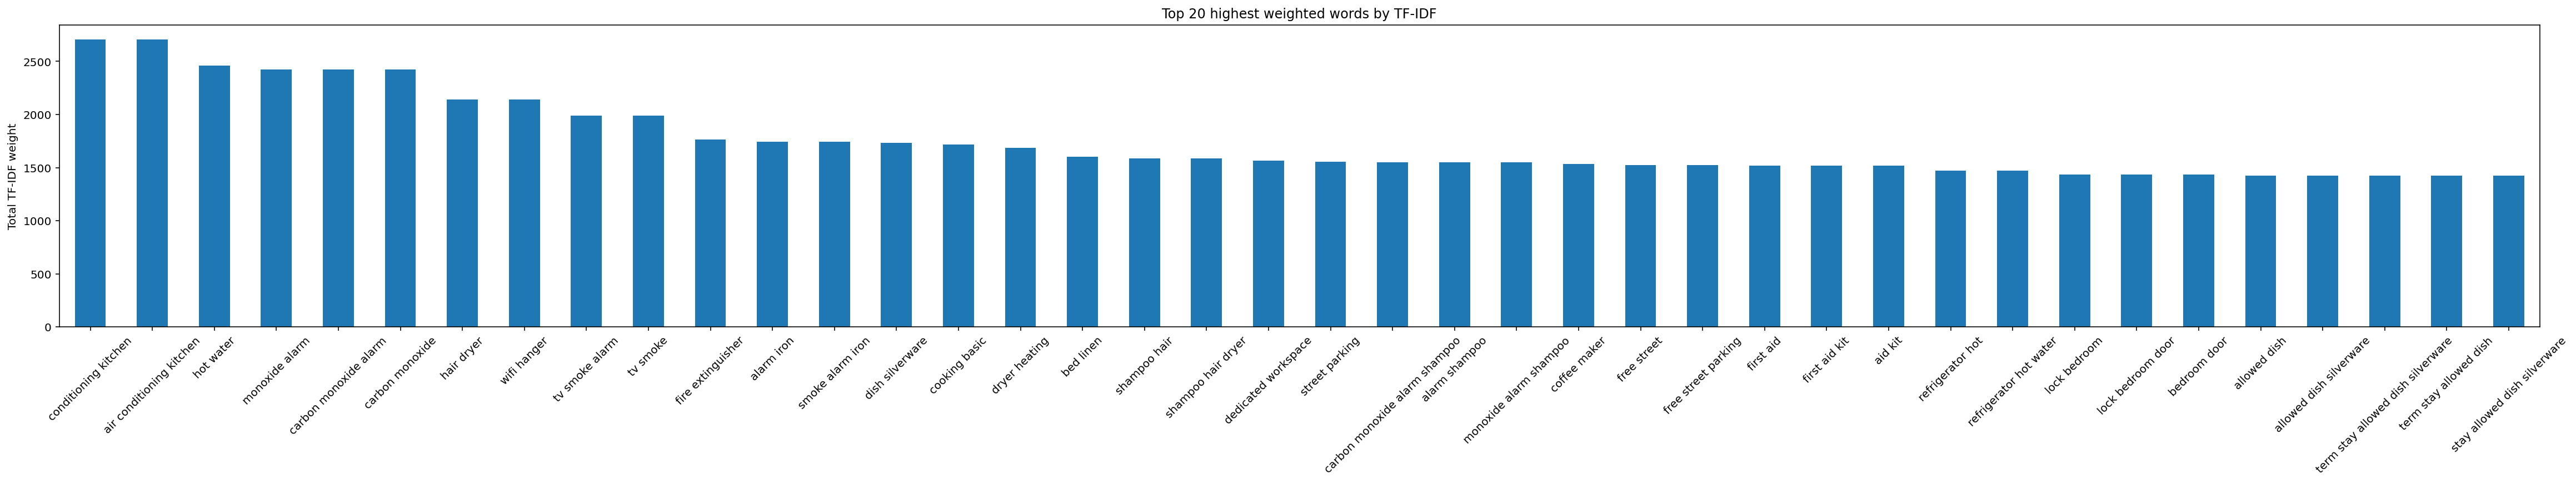

In [ ]:

word_importance = pd.DataFrame(
    {"importance": df_desc_transformed.toarray().sum(axis=0)},
    index=tfidf.get_feature_names()
).sort_values("importance", ascending=False)

word_importance.head(40).plot(kind="bar", figsize=(40, 5), legend=False)
plt.title("Top 20 highest weighted words by TF-IDF")
plt.ylabel("Total TF-IDF weight")
plt.xticks(rotation=45)
plt.show()


BAGS OF WORD:

In [ ]:


# using bags of words
bagofwords = CountVectorizer(min_df=.20, max_df=.80,
                             tokenizer=custom_tokenizer,token_pattern=r'(?u)\b[A-Za-z]+\b',
                            ngram_range=(2,3))  # we will capture from one word to three words tokens

# Fit & Transform
X_train_transformed = bagofwords.fit_transform(X_train['amenities'])



In [ ]:

# calculate the occurrence of each token
words = bagofwords.get_feature_names_out()
word_counts = X_train_transformed.toarray().sum(axis=0)
count_df = pd.DataFrame({'token': words, 'counts': word_counts})
print(f'There are {len(count_df)} tokens in total.')


# set token column as index column

count_df=count_df.sort_values(by=['counts'],ascending=False).set_index(['token'])
count_df[:5]


There are 75 tokens in total.


counts
token                        
hot water               21722
monoxide alarm          19848
carbon monoxide alarm   19848
carbon monoxide         19848
hair dryer              17027

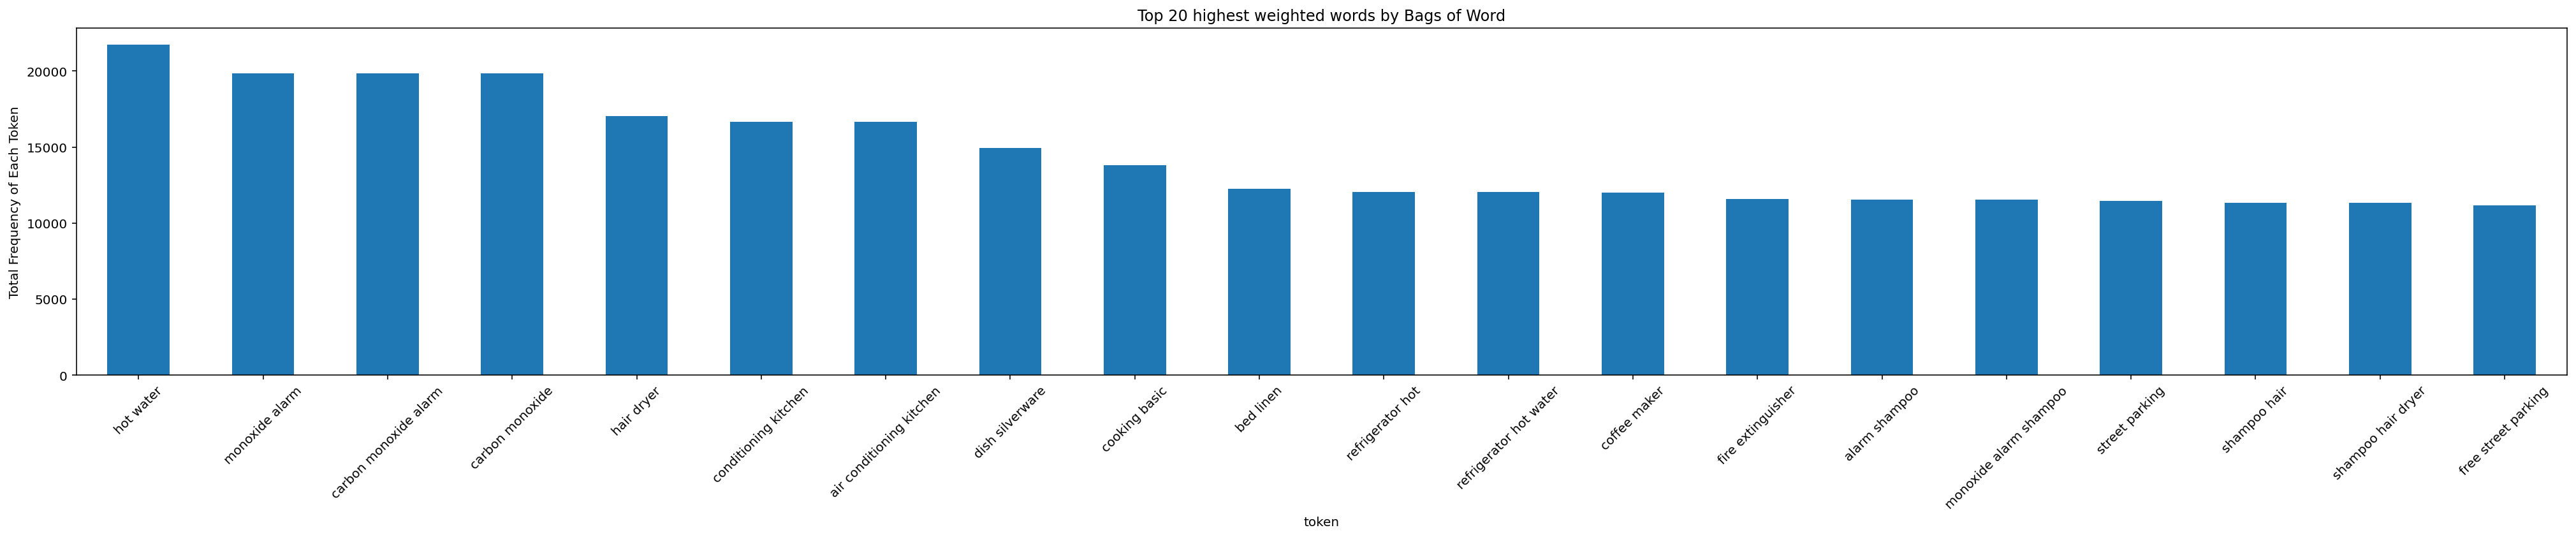

In [ ]:
count_df.head(20).plot(kind="bar", figsize=(35, 5), legend=False)
plt.title("Top 20 highest weighted words by Bags of Word")
plt.ylabel("Total Frequency of Each Token")
plt.xticks(rotation=45)
plt.show()

After adjusting the parameters of TF-IDF and analyzing both model results, we have decided to include the tokens below:

In [ ]:
amenities_list=['refrigerator','kitchen','washer','paid parking','free parking on premises','street parking','gym','breakfast','elevator','security','host greets you','dedicated workspace']

We feel that `dedicated workspace`, `gym`,`elevator`, or `washer` should be crucial for tourists or visitors for business purposes. Having a decent washer or dishwasher in an apt has been a problem for NYC residents too. Let's check how much of percentage of the rows including these tags:

In [ ]:
for i in amenities_list:
  a=(X_train[X_train['amenities'].str.contains(i)].count()['amenities']/len(X_train)).round(2)

  print(f'{i}: {a}')

refrigerator: 0.6
kitchen: 0.89
washer: 0.46
paid parking: 0.15
free parking on premises: 0.12
street parking: 0.45
gym: 0.09
breakfast: 0.05
elevator: 0.21
security: 0.23
host greets you: 0.13
dedicated workspace: 0.32


Only 10% of the training listings include gym while 42% of the listings have a dedicated workspace which may be a good indicator to predict the price. 30% of the listings include security cameras in their amenities. This may have a negative or positive impact on the price column.

In [ ]:
# Extract all the tags from three dataset by using NumPy function

X_train['amenities_kitchen'] = np.where(X_train['amenities'].str.contains('kitchen'),1,0)
X_train['amenities_washer'] = np.where(X_train['amenities'].str.contains('washer'),1,0)
X_train['amenities_paid_parking'] = np.where(X_train['amenities'].str.contains('paid parking'),1,0)
X_train['amenities_free_parking'] = np.where(X_train['amenities'].str.contains('free parking on premises'),1,0)
X_train['amenities_street_parking'] = np.where(X_train['amenities'].str.contains('street parking'),1,0)
X_train['amenities_gym'] = np.where(X_train['amenities'].str.contains('gym'),1,0)
X_train['amenities_breakfast'] = np.where(X_train['amenities'].str.contains('breakfast'),1,0)
X_train['amenities_elevator']=np.where(X_train['amenities'].str.contains('elevator'),1,0)
X_train['amenities_security']=np.where(X_train['amenities'].str.contains('security camera'),1,0)
X_train['amenities_host_greets_you']=np.where(X_train['amenities'].str.contains('host greets you'),1,0)
X_train['amenities_dedicated_workspace']=np.where(X_train['amenities'].str.contains('dedicated workspace'),1,0)

X_test['amenities_kitchen'] = np.where(X_test['amenities'].str.contains('kitchen'),1,0)
X_test['amenities_washer'] = np.where(X_test['amenities'].str.contains('washer'),1,0)
X_test['amenities_paid_parking'] = np.where(X_test['amenities'].str.contains('paid parking'),1,0)
X_test['amenities_free_parking'] = np.where(X_test['amenities'].str.contains('free parking on premises'),1,0)
X_test['amenities_street_parking'] = np.where(X_test['amenities'].str.contains('street parking'),1,0)
X_test['amenities_gym'] = np.where(X_test['amenities'].str.contains('gym'),1,0)
X_test['amenities_breakfast'] = np.where(X_test['amenities'].str.contains('breakfast'),1,0)
X_test['amenities_elevator']=np.where(X_test['amenities'].str.contains('elevator'),1,0)
X_test['amenities_security']=np.where(X_test['amenities'].str.contains('security camera'),1,0)
X_test['amenities_host_greets_you']=np.where(X_test['amenities'].str.contains('host greets you'),1,0)
X_test['amenities_dedicated_workspace']=np.where(X_test['amenities'].str.contains('dedicated workspace'),1,0)

In [ ]:
# Drop the original column from all datasets:

X_train=X_train.drop('amenities',axis=1)
X_test=X_test.drop('amenities',axis=1)

2. `name`: Name column refers to the listing title. There may be some catchy words which customers seek and are willing to pay extra for them.

In [ ]:
# Get rid of any punctuations in the reviews though we do not know if there is any
print(string.punctuation)



!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [ ]:
ENGLISH_STOP_WORDS = stopwords.words('english')
numbers=[1,2,3,4,5,6,7,8,9,0,"bguest", "bedroom",'bother thing','notebbr','bthe spacebbr','bother','br','new york','new york city','private']
for n in numbers:
  ENGLISH_STOP_WORDS.append(n)
print(ENGLISH_STOP_WORDS)

# Name stemmer and lemmatizer
stemmer = nltk.stem.PorterStemmer()
lemmatizer = WordNetLemmatizer()

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
def custom_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:    #eliminate punctuation marks
        sentence = sentence.replace(punctuation_mark,'').lower()  #lower all words

    # split sentence into words
    listofwords = sentence.split(' ')
    listoflemmatized_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            lemmatized_word = lemmatizer.lemmatize(word)
            listoflemmatized_words.append(lemmatized_word)

    return listoflemmatized_words

In [ ]:

# using our custom tokenizer in TfidfVectorizer
tfidf = TfidfVectorizer(min_df=100,max_df=.80, token_pattern=r'(?u)\b[A-Za-z]+\b',
                        tokenizer=custom_tokenizer,ngram_range=(2,5))
tfidf.fit(X_train["name"])

df_desc_transformed = tfidf.transform(X_train["name"])


In [ ]:

tfidf_df = pd.DataFrame(columns=tfidf.get_feature_names(), data=df_desc_transformed .toarray())
display(tfidf_df)



1 apartment  1 apt  1 bed  15 min  2 apartment  2 apt  2 bath  2 bed  \
0              0.0    0.0    0.0     0.0          0.0    0.0     0.0    0.0   
1              0.0    0.0    0.0     0.0          0.0    0.0     0.0    0.0   
2              0.0    0.0    0.0     0.0          0.0    0.0     0.0    0.0   
3              0.0    0.0    0.0     0.0          0.0    0.0     0.0    0.0   
4              0.0    0.0    0.0     0.0          0.0    0.0     0.0    0.0   
...            ...    ...    ...     ...          ...    ...     ...    ...   
25102          0.0    0.0    0.0     0.0          0.0    0.0     0.0    0.0   
25103          0.0    0.0    0.0     0.0          0.0    0.0     0.0    0.0   
25104          0.0    0.0    0.0     0.0          0.0    0.0     0.0    0.0   
25105          0.0    0.0    0.0     0.0          0.0    0.0     0.0    0.0   
25106          0.0    0.0    0.0     0.0          0.0    0.0     0.0    0.0   

       20 min  apartment brooklyn  ...  studio heart  sunny room  time square  \
0         0.0                 0.0  ...           0.0         0.0          0.0   
1         0.0                 0.0  ...           0.0         1.0          0.0   
2         0.0                 0.0  ...           0.0         0.0          0.0   
3         0.0                 0.0  ...           0.0         0.0          0.0   
4         0.0                 0.0  ...           0.0         0.0          0.0   
...       ...                 ...  ...           ...         ...          ...   
25102     0.0                 0.0  ...           0.0         0.0          0.0   
25103     0.0                 0.0  ...           0.0         0.0          0.0   
25104     0.0                 0.0  ...           0.0         0.0          0.0   
25105     0.0                 0.0  ...           0.0         0.0          0.0   
25106     0.0                 0.0  ...           0.0         0.0          0.0   

       untitled freeman  upper east  upper east side  upper west  \
0                   0.0         0.0              0.0         0.0   
1                   0.0         0.0              0.0         0.0   
2                   0.0         0.0              0.0         0.0   
3                   0.0         0.0              0.0         0.0   
4                   0.0         0.0              0.0         0.0   
...                 ...         ...              ...         ...   
25102               0.0         0.0              0.0         0.0   
25103               0.0         0.0              0.0         0.0   
25104               0.0         0.0              0.0         0.0   
25105               0.0         0.0              0.0         0.0   
25106               0.0         0.0              0.0         0.0   

       upper west side  west side  west village  
0                  0.0        0.0           0.0  
1                  0.0        0.0           0.0  
2                  0.0        0.0           0.0  
3                  0.0        0.0           0.0  
4                  0.0        0.0           0.0  
...                ...        ...           ...  
25102              0.0        0.0           0.0  
25103              0.0        0.0           0.0  
25104              0.0        0.0           0.0  
25105              0.0        0.0           0.0  
25106              0.0        0.0           0.0  

[25107 rows x 63 columns]

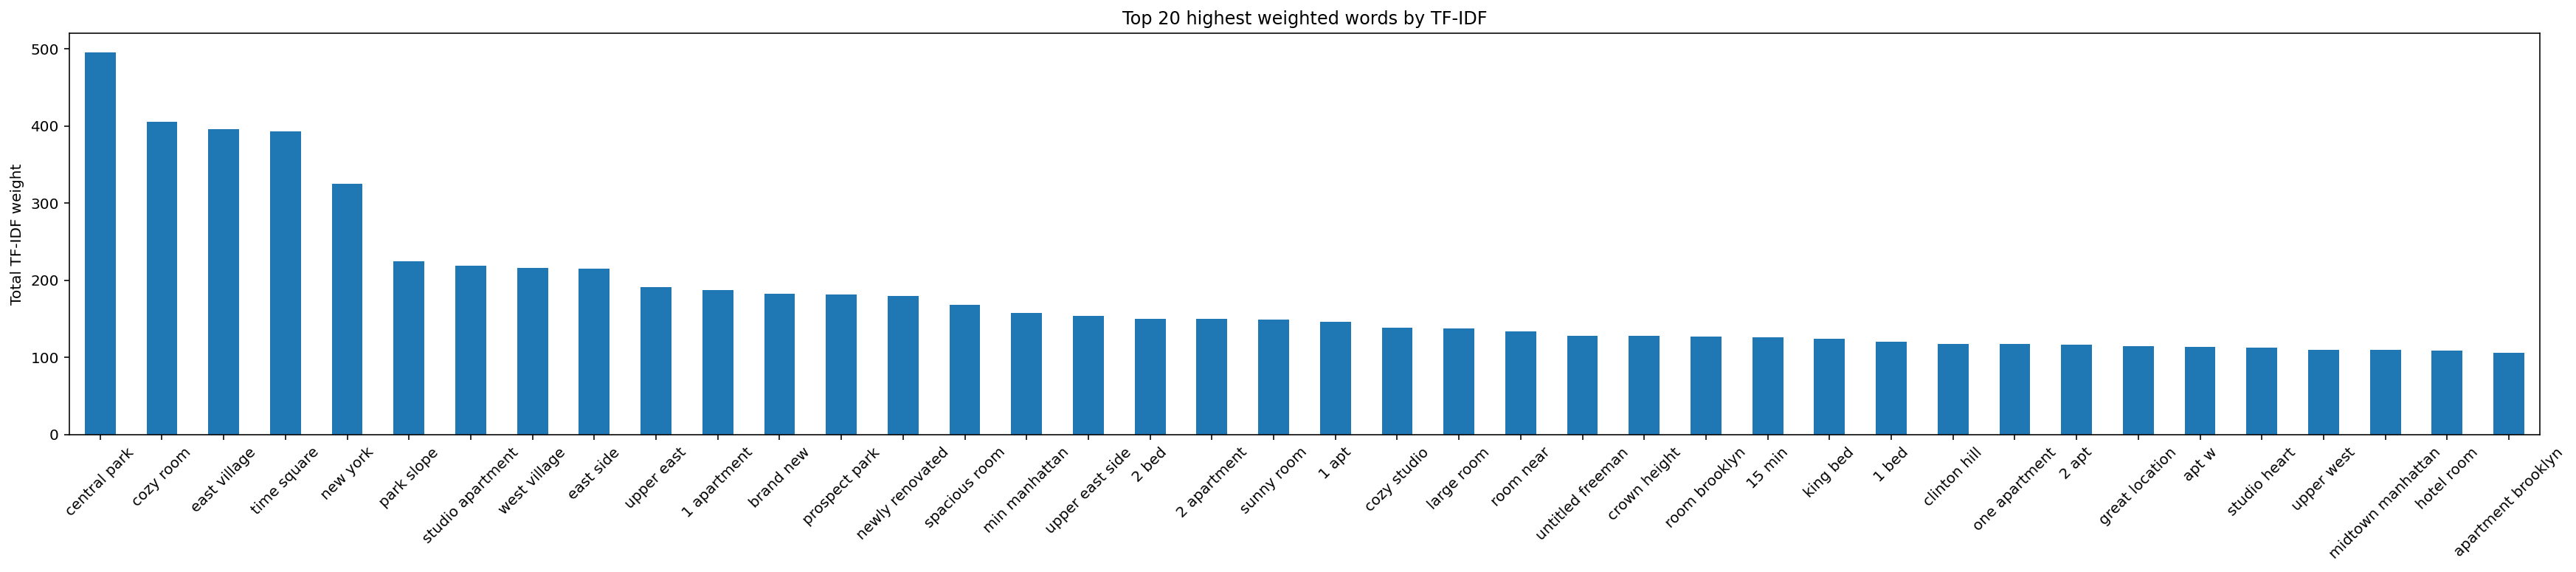

In [ ]:

word_importance = pd.DataFrame(
    {"importance": df_desc_transformed.toarray().sum(axis=0)},
    index=tfidf.get_feature_names()
).sort_values("importance", ascending=False)

word_importance.head(40).plot(kind="bar", figsize=(30, 5), legend=False)
plt.title("Top 20 highest weighted words by TF-IDF")
plt.ylabel("Total TF-IDF weight")
plt.xticks(rotation=45)
plt.show()



We have selected mostly landmark or neighborhood names:

In [ ]:
name_df=tfidf_df[['studio apartment','central park','time square','east village','upper east side','park slope','west village','prospect park']]
name_df

studio apartment  central park  time square  east village  \
0                   0.0           0.0          0.0           0.0   
1                   0.0           0.0          0.0           0.0   
2                   0.0           0.0          0.0           0.0   
3                   0.0           0.0          0.0           0.0   
4                   0.0           0.0          0.0           0.0   
...                 ...           ...          ...           ...   
25102               0.0           0.0          0.0           0.0   
25103               0.0           0.0          0.0           0.0   
25104               0.0           0.0          0.0           0.0   
25105               0.0           0.0          0.0           0.0   
25106               0.0           0.0          0.0           0.0   

       upper east side  park slope  west village  prospect park  
0                  0.0         0.0           0.0            0.0  
1                  0.0         0.0           0.0            0.0  
2                  0.0         0.0           0.0            0.0  
3                  0.0         0.0           0.0            0.0  
4                  0.0         0.0           0.0            0.0  
...                ...         ...           ...            ...  
25102              0.0         0.0           0.0            0.0  
25103              0.0         0.0           0.0            0.0  
25104              0.0         0.0           0.0            0.0  
25105              0.0         0.0           0.0            0.0  
25106              0.0         0.0           0.0            0.0  

[25107 rows x 8 columns]

In [ ]:
name_df=name_df.reset_index(drop=True)

In [ ]:
name_df.columns=['name_studio apartment','name_central park','name_time square','name_east village','name_upper east side','name_park slope','name_west village','name_prospect park']

In [ ]:
name_df

name_studio apartment  name_central park  name_time square  \
0                        0.0                0.0               0.0   
1                        0.0                0.0               0.0   
2                        0.0                0.0               0.0   
3                        0.0                0.0               0.0   
4                        0.0                0.0               0.0   
...                      ...                ...               ...   
25102                    0.0                0.0               0.0   
25103                    0.0                0.0               0.0   
25104                    0.0                0.0               0.0   
25105                    0.0                0.0               0.0   
25106                    0.0                0.0               0.0   

       name_east village  name_upper east side  name_park slope  \
0                    0.0                   0.0              0.0   
1                    0.0                   0.0              0.0   
2                    0.0                   0.0              0.0   
3                    0.0                   0.0              0.0   
4                    0.0                   0.0              0.0   
...                  ...                   ...              ...   
25102                0.0                   0.0              0.0   
25103                0.0                   0.0              0.0   
25104                0.0                   0.0              0.0   
25105                0.0                   0.0              0.0   
25106                0.0                   0.0              0.0   

       name_west village  name_prospect park  
0                    0.0                 0.0  
1                    0.0                 0.0  
2                    0.0                 0.0  
3                    0.0                 0.0  
4                    0.0                 0.0  
...                  ...                 ...  
25102                0.0                 0.0  
25103                0.0                 0.0  
25104                0.0                 0.0  
25105                0.0                 0.0  
25106                0.0                 0.0  

[25107 rows x 8 columns]

In [ ]:
X_train=X_train.reset_index(drop=True)

In [ ]:
# Merge the encoded data with the main dataframe
X_train=X_train.join(name_df)

NAME: TRANSFORM | TEST SET : We will follow the same steps

In [ ]:

df_desc_transformed = tfidf.transform(X_test["name"])


In [ ]:

tfidf_df = pd.DataFrame(columns=tfidf.get_feature_names(), data=df_desc_transformed .toarray())



In [ ]:
name_df=tfidf_df[['studio apartment','central park','time square','east village','upper east side','park slope','west village','prospect park']]

In [ ]:
name_df=name_df.reset_index(drop=True)

In [ ]:
name_df.columns=['name_studio apartment','name_central park','name_time square','name_east village','name_upper east side','name_park slope','name_west village','name_prospect park'] 

In [ ]:
X_test=X_test.reset_index(drop=True)

In [ ]:
X_test=X_test.join(name_df)

In [ ]:
# Drop the original column from all datasets:

X_train=X_train.drop('name',axis=1)
X_test=X_test.drop('name',axis=1)

3. `description`: Airbnb descriptions involve lots of useful information. However we will select the most significant and relevant tokens for this project to preserve the ratio between features and data points..

In [ ]:
# Quick look
X_train['description'][0]

'Large Rustic 3 bedroom apartment in Bedstuy. Located in a charming brownstone. This property has been in the family for many years. <br />The apartment has 3 bedrooms, one queen size bed in the master bedroom, one full size bed in the second bedroom and one twin in the third bedroom.<br />You will have a fully equipped kitchen with a dishwasher, stove, oven, microwave and fridge. Dining table seats 4. <br />Wifi, Television with cable, and air conditioner. The entire floor is for your to use. Private entrance.<br /><br /><b>The space</b><br />3 Bedroom Apartment fits 5 people.'

In [ ]:
# Clean up a little bit
X_train['description']=X_train['description'].str.replace('<br />','')


In [ ]:
X_train['description'][0]

'Large Rustic 3 bedroom apartment in Bedstuy. Located in a charming brownstone. This property has been in the family for many years. The apartment has 3 bedrooms, one queen size bed in the master bedroom, one full size bed in the second bedroom and one twin in the third bedroom.You will have a fully equipped kitchen with a dishwasher, stove, oven, microwave and fridge. Dining table seats 4. Wifi, Television with cable, and air conditioner. The entire floor is for your to use. Private entrance.<b>The space</b>3 Bedroom Apartment fits 5 people.'

In [ ]:
# using our custom tokenizer in TfidfVectorizer
tfidf = TfidfVectorizer(min_df=.01,max_df=.75, token_pattern=r'(?u)\b[A-Za-z]+\b',
                        tokenizer=custom_tokenizer,ngram_range=(3,4))
tfidf.fit(X_train["description"])

df_desc_transformed = tfidf.transform(X_train["description"])

In [ ]:
tfidf_df = pd.DataFrame(columns=tfidf.get_feature_names(), data=df_desc_transformed .toarray())
display(tfidf_df)

10 minute walk  2 block away  5 min walk  5 minute walk  \
0                 0.0           0.0         0.0            0.0   
1                 0.0           0.0         0.0            0.0   
2                 0.0           0.0         0.0            0.0   
3                 0.0           0.0         0.0            0.0   
4                 0.0           0.0         0.0            0.0   
...               ...           ...         ...            ...   
25102             0.0           0.0         0.0            0.0   
25103             0.0           0.0         0.0            0.0   
25104             0.0           0.0         0.0            0.0   
25105             0.0           0.0         0.0            0.0   
25106             0.0           0.0         0.0            0.0   

       access entire apartment  adventurer business traveler  \
0                          0.0                           0.0   
1                          0.0                           0.0   
2                          0.0                           0.0   
3                          0.0                           0.0   
4                          0.0                           0.0   
...                        ...                           ...   
25102                      0.0                           0.0   
25103                      0.0                           0.0   
25104                      0.0                           0.0   
25105                      0.0                           0.0   
25106                      0.0                           0.0   

       bathroom living room  bed living room  couple solo adventurer  \
0                       0.0              0.0                     0.0   
1                       0.0              0.0                     0.0   
2                       0.0              0.0                     0.0   
3                       0.0              0.0                     0.0   
4                       0.0              0.0                     0.0   
...                     ...              ...                     ...   
25102                   0.0              0.0                     0.0   
25103                   0.0              0.0                     0.0   
25104                   0.0              0.0                     0.0   
25105                   0.0              0.0                     0.0   
25106                   0.0              0.0                     0.0   

       couple solo adventurer business  ...  queen size bed  queen sized bed  \
0                                  0.0  ...        0.520670              0.0   
1                                  0.0  ...        0.502901              0.0   
2                                  0.0  ...        0.000000              1.0   
3                                  0.0  ...        0.000000              0.0   
4                                  0.0  ...        0.000000              0.0   
...                                ...  ...             ...              ...   
25102                              0.0  ...        0.000000              0.0   
25103                              0.0  ...        0.000000              0.0   
25104                              0.0  ...        1.000000              0.0   
25105                              0.0  ...        0.000000              0.0   
25106                              0.0  ...        0.000000              0.0   

       solo adventurer business  solo adventurer business traveler  \
0                           0.0                                0.0   
1                           0.0                                0.0   
2                           0.0                                0.0   
3                           0.0                                0.0   
4                           0.0                                0.0   
...                         ...                                ...   
25102                       0.0                                0.0   
25103                       0.0                            

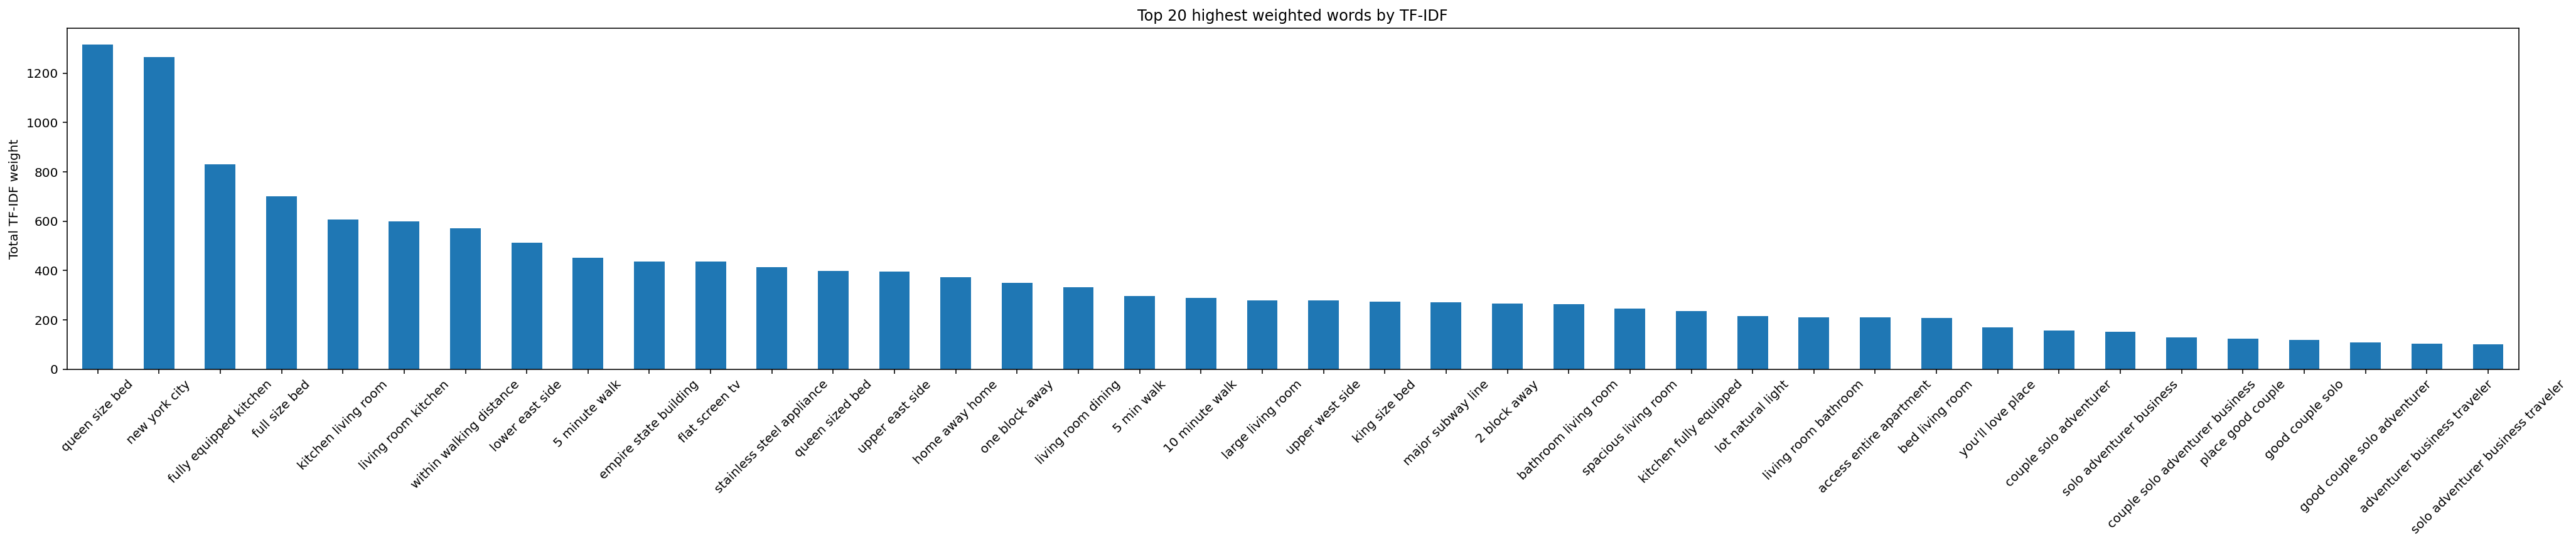

In [ ]:
word_importance = pd.DataFrame(
    {"importance": df_desc_transformed.toarray().sum(axis=0)},
    index=tfidf.get_feature_names()
).sort_values("importance", ascending=False)

word_importance.head(40).plot(kind="bar", figsize=(35, 5), legend=False)
plt.title("Top 20 highest weighted words by TF-IDF")
plt.ylabel("Total TF-IDF weight")
plt.xticks(rotation=45)
plt.show()

The most relevant tokens include another landmark called Empire State Building or neighborhood names such as lower east side. We have also added information about the bed size because we think it may impact the customers' decision.

In [ ]:
description_df=tfidf_df[['empire state building','within walking distance','one block away','queen size bed','full size bed','king size bed','fully equipped kitchen','lower east side']] #'major subway line','5 minute walk','upper west side',

In [ ]:
description_df.columns=['descr_empire state building','descr_within walking distance','descr_one block away','descr_queen size bed','descr_full size bed','descr_king size bed','descr_fully equipped kitchen','descr_lower east side'] #'descr_major subway line','descr_5 minute walk','descr_upper west side',

In [ ]:
description_df=description_df.reset_index(drop=True)

In [ ]:
X_train=X_train.join(description_df)

Last but not least, we wanted to check if any apartments have a doorman too. Those apartments are generally residential buildings. Thus we want to create a column for it too.

In [ ]:
X_train['desc_doorman']=np.where(X_train.description.str.contains('doorman'),1,0)
X_train['desc_doorman'].value_counts()

0    24447
1      660
Name: desc_doorman, dtype: int64

We have decided to drop it because only few listings include the doorman token in their desccriptions.

In [ ]:
X_train=X_train.drop('desc_doorman', axis=1)

KeyError: ignored

TRANSFORM DESCRIPTION | TEST SET

In [ ]:
df_desc_transformed = tfidf.transform(X_test["description"])

In [ ]:
tfidf_df = pd.DataFrame(columns=tfidf.get_feature_names(), data=df_desc_transformed .toarray())


In [ ]:
description_df=tfidf_df[['empire state building','within walking distance','one block away','queen size bed','full size bed','king size bed','fully equipped kitchen','lower east side']] #'upper west side','major subway line','5 minute walk',

In [ ]:
description_df=description_df.reset_index(drop=True)

In [ ]:
description_df.columns=['descr_empire state building','descr_within walking distance','descr_one block away','descr_queen size bed','descr_full size bed','descr_king size bed','descr_fully equipped kitchen','descr_lower east side'] #'descr_upper west side','descr_major subway line','descr_5 minute walk',

In [ ]:
X_test=X_test.join(description_df)

In [ ]:
# Drop the original column from all datasets:

X_train=X_train.drop('description',axis=1)
X_test=X_test.drop('description',axis=1)

### **Encoding the Categorical Columns**
---






*   Fit and transform the training dataset:



In [ ]:
# Extract all the string categories
categorical_df = X_train.dtypes[X_train.dtypes == np.object]  # filtering by string categoricals
categorical_df_cols = categorical_df.index.tolist()  # list of categorical fields

categorical_df_cols

['host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'neighbourhood_group_cleansed',
 'room_type']

In [ ]:
# Create instance of one-hot-encoder
ohe = OneHotEncoder()
# Pass the cat columns
ohe_df = ohe.fit_transform(X_train[[
'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'neighbourhood_group_cleansed',
 'room_type']])


OHE_column_name = ohe.get_feature_names_out([
'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'neighbourhood_group_cleansed',
 'room_type'])

# Convert it into a dataframe
one_hot_encoded_frame = pd.DataFrame.sparse.from_spmatrix(ohe_df, columns=OHE_column_name)
one_hot_encoded_frame=one_hot_encoded_frame.sparse.to_dense()




# Drop the original categorical columns
X_train.drop(columns=['host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'neighbourhood_group_cleansed',
 'room_type'],inplace=True)




In [ ]:
# Merge the encoded dataframe with main df bridge_df on key values

X_train = pd.concat([X_train,one_hot_encoded_frame], axis=1)


In [ ]:
# Quick check 
X_train.head()

host_is_superhost  accommodates  minimum_nights  maximum_nights  \
0                0.0           5.0             3.0              15   
1                0.0           2.0            30.0            1125   
2                0.0           2.0             4.0              30   
3                0.0           2.0             6.0             365   
4                0.0           3.0            30.0            1125   

   availability_30  number_of_reviews  number_of_reviews_l30d  \
0                0                 42                       1   
1                0                  9                       0   
2                5                 75                       1   
3               14                  7                       0   
4                1                  0                       0   

   review_scores_location  review_scores_value  instant_bookable  ...  \
0                    4.62                 4.57                 0  ...   
1                    4.89                 5.00                 0  ...   
2                    4.79                 4.73                 0  ...   
3                    5.00                 4.67                 0  ...   
4                    5.00                 4.65                 0  ...   

   host_acceptance_rate_26-50%  host_acceptance_rate_51-75%  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          1.0                          0.0   
4                          1.0                          0.0   

   host_acceptance_rate_76-100%  neighbourhood_group_cleansed_Bronx  \
0                           1.0                                 0.0   
1                           1.0                                 0.0   
2                           1.0                                 0.0   
3                           0.0                                 0.0   
4                           0.0                                 0.0   

   neighbourhood_group_cleansed_Brooklyn  \
0                                    1.0   
1                                    1.0   
2                                    0.0   
3                                    1.0   
4                                    0.0   

   neighbourhood_group_cleansed_Manhattan  \
0                                     0.0   
1                                     0.0   
2                                     0.0   
3                                     0.0   
4                                     1.0   

   neighbourhood_group_cleansed_Queens  \
0                                  0.0   
1                                  0.0   
2                                  1.0   
3                                  0.0   
4                                  0.0   

   neighbourhood_group_cleansed_Staten Island  room_type_Entire home/apt  \
0                                         0.0                        1.0   
1                                         0.0                        0.0   
2                                         0.0                        0.0   
3                                         0.0                        1.0   
4                                         0.0                        1.0   

   room_type_Private room  
0                     0.0  
1                     1.0  
2                     1.0  
3                     0.0  
4                     0.0  

[5 rows x 71 columns]

Let's follow the steps for the test dataset:

In [ ]:
# OHE

# Pass the cat columns
ohe_df = ohe.transform(X_test[[
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'neighbourhood_group_cleansed',
 'room_type']])

# Convert it into a dataframe
one_hot_encoded_frame = pd.DataFrame.sparse.from_spmatrix(ohe_df, columns=OHE_column_name)
one_hot_encoded_frame=one_hot_encoded_frame.sparse.to_dense()



# Drop the original categorical columns
X_test.drop(columns=['host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'neighbourhood_group_cleansed',
 'room_type'],inplace=True)




In [ ]:
# Merge the encoded dataframe with main df 
X_test = X_test.join(one_hot_encoded_frame)

X_test.shape

(6277, 71)

### **Optimizing the skew in the independent variables:**

---





*   Fit and transform the train dataset:



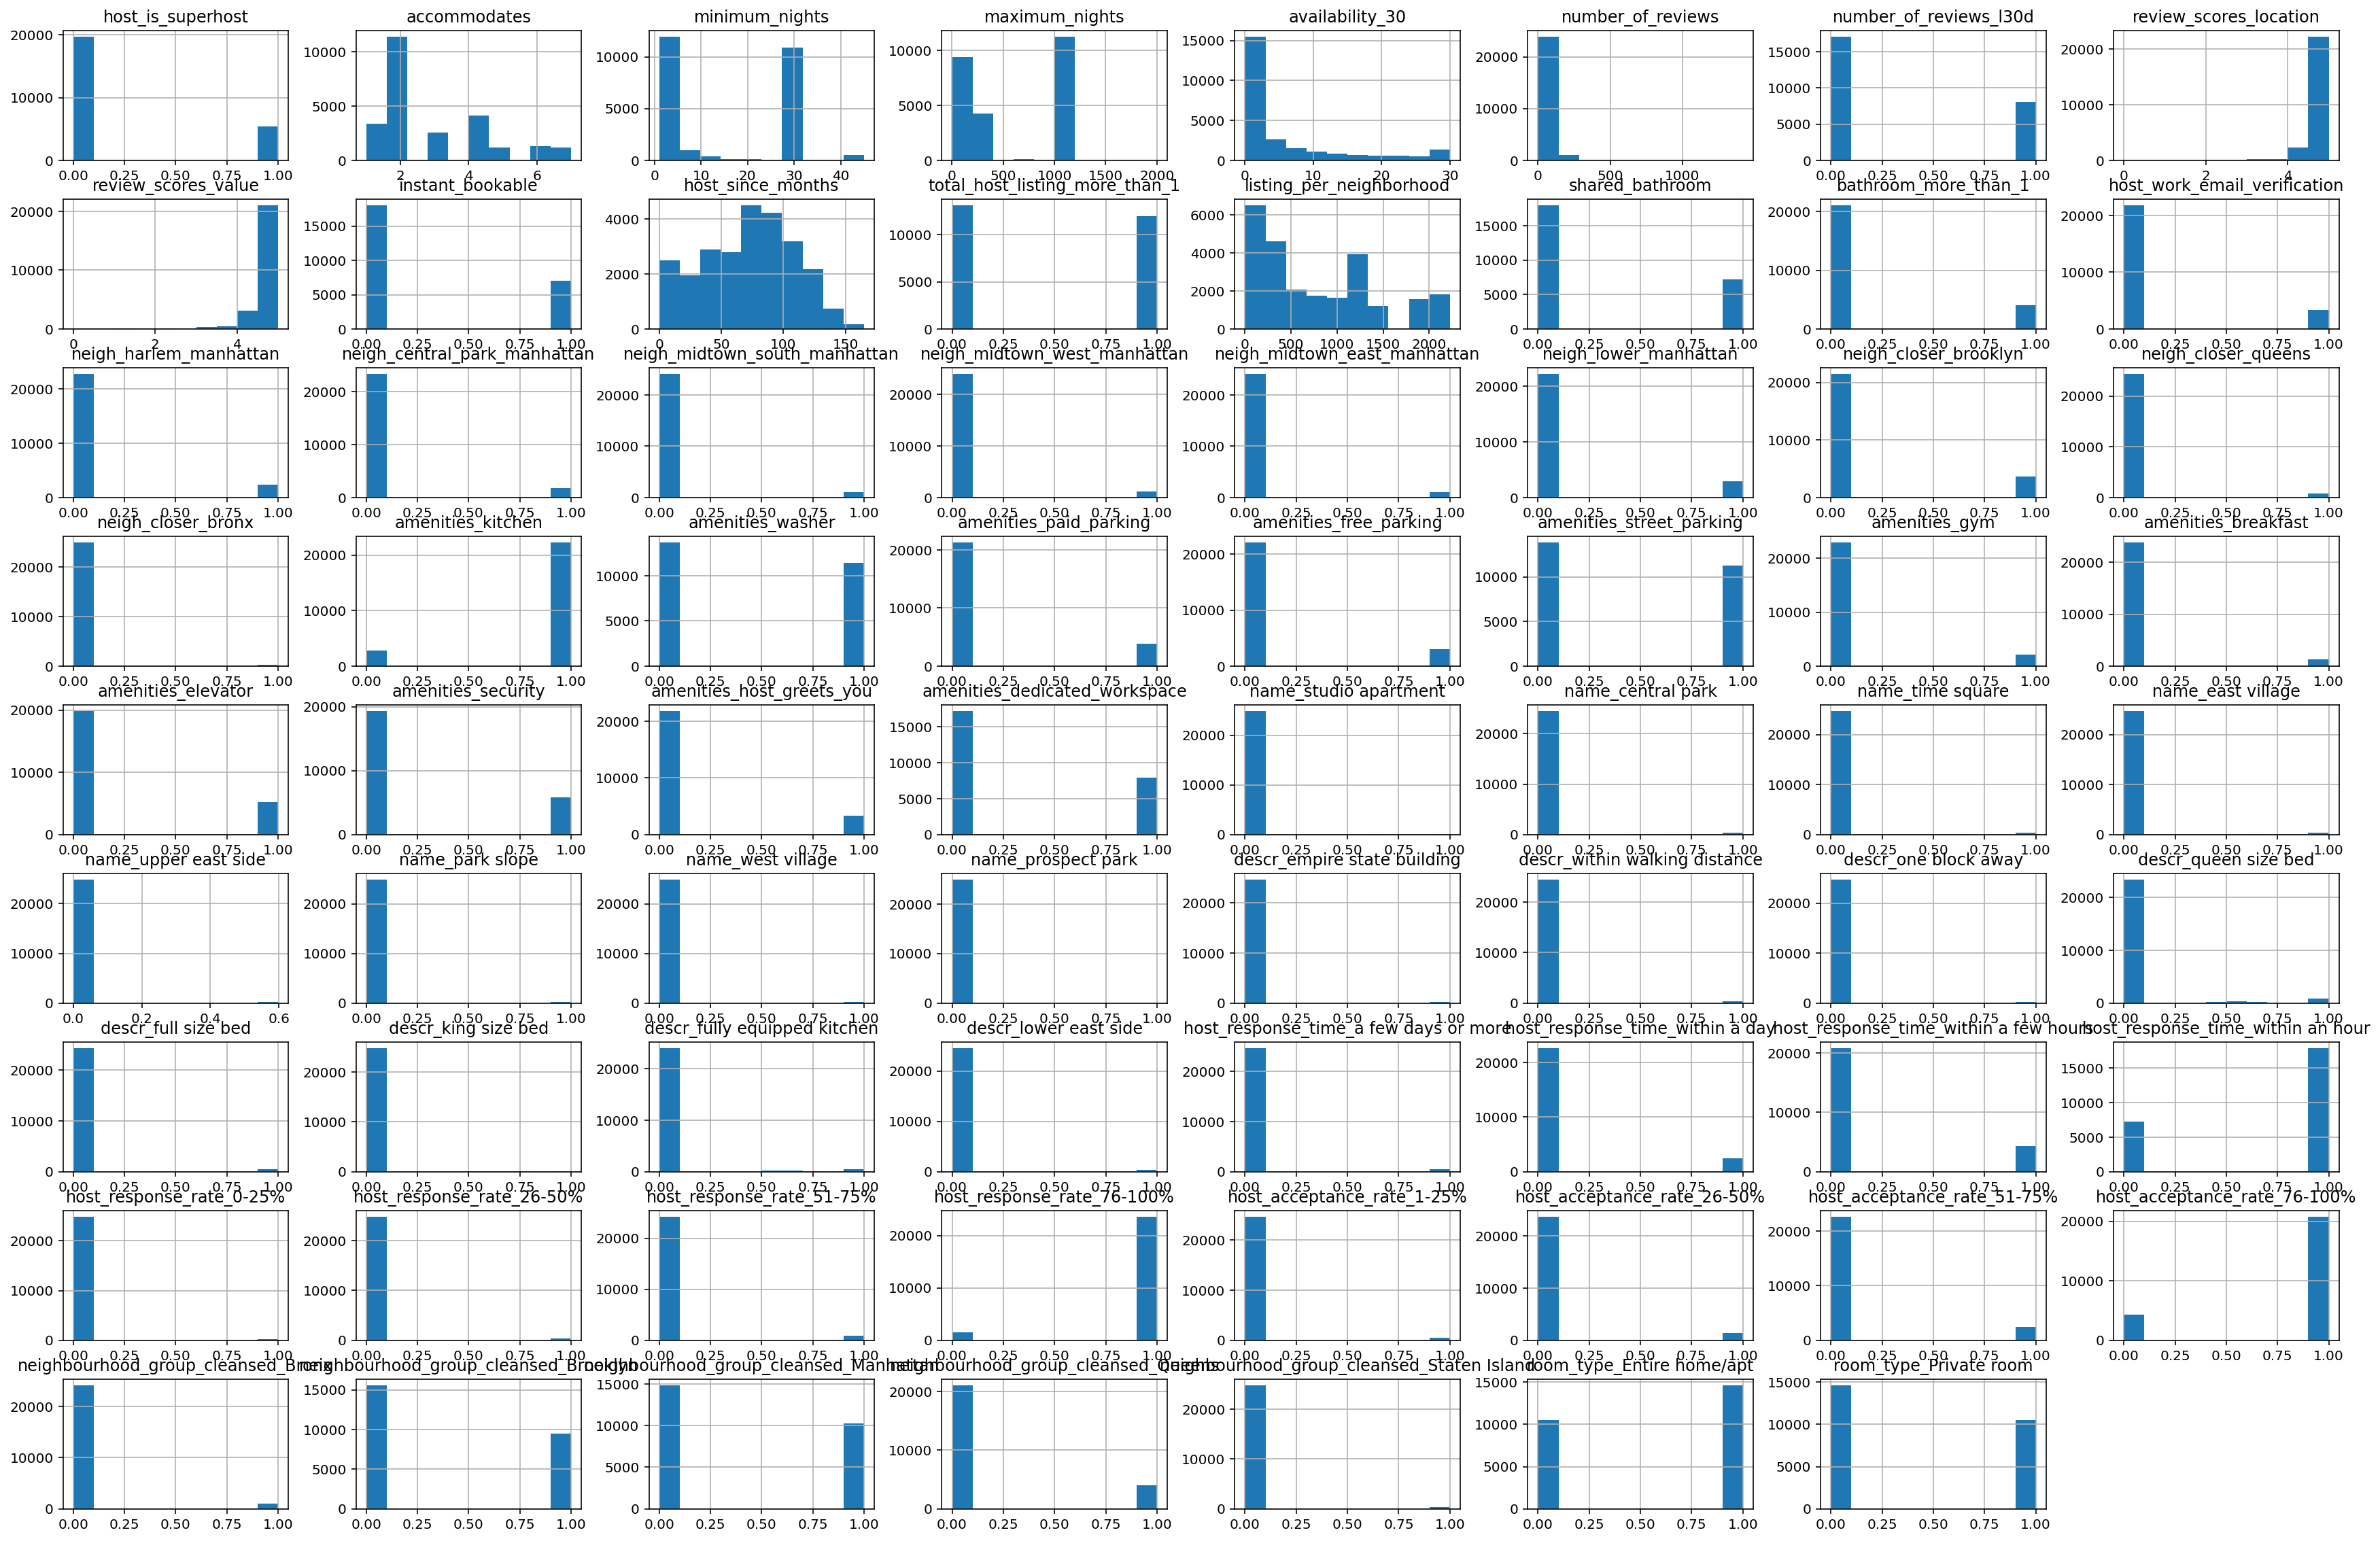

In [ ]:
# Plot the distribution of transformed numerical categories 
X_train_num=X_train.select_dtypes(include='number')
X_train_num.hist(figsize=(30,20));

In [ ]:
# Recall the column names
X_train.columns

Index(['host_is_superhost', 'accommodates', 'minimum_nights', 'maximum_nights',
       'availability_30', 'number_of_reviews', 'number_of_reviews_l30d',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'host_since_months', 'total_host_listing_more_than_1',
       'listing_per_neighborhood', 'shared_bathroom', 'bathroom_more_than_1',
       'host_work_email_verification', 'neigh_harlem_manhattan',
       'neigh_central_park_manhattan', 'neigh_midtown_south_manhattan',
       'neigh_midtown_west_manhattan', 'neigh_midtown_east_manhattan',
       'neigh_lower_manhattan', 'neigh_closer_brooklyn', 'neigh_closer_queens',
       'neigh_closer_bronx', 'amenities_kitchen', 'amenities_washer',
       'amenities_paid_parking', 'amenities_free_parking',
       'amenities_street_parking', 'amenities_gym', 'amenities_breakfast',
       'amenities_elevator', 'amenities_security', 'amenities_host_greets_you',
       'amenities_dedicated_workspace', 'name_studio apartm

Highly skewed columns are the ones which were not normally distributed. The details are below:

In [ ]:
# Select the highly skewed features in X_train dataset
X_train_skewed=X_train[[ 'review_scores_location','availability_30', 'number_of_reviews','minimum_nights','maximum_nights',
       'review_scores_value','host_since_months','listing_per_neighborhood', 'accommodates']] 

In [ ]:
X_train_skewed

review_scores_location  availability_30  number_of_reviews  \
0                        4.62                0                 42   
1                        4.89                0                  9   
2                        4.79                5                 75   
3                        5.00               14                  7   
4                        5.00                1                  0   
...                       ...              ...                ...   
25102                    4.89                0                  9   
25103                    4.95                5                246   
25104                    4.68                6                172   
25105                    4.80               20                149   
25106                    4.91                7                 11   

       minimum_nights  maximum_nights  review_scores_value  host_since_months  \
0                 3.0              15                 4.57               37.0   
1                30.0            1125                 5.00              110.0   
2                 4.0              30                 4.73               46.0   
3                 6.0             365                 4.67               62.0   
4                30.0            1125                 4.65              103.0   
...               ...             ...                  ...                ...   
25102             1.0             365                 5.00               45.0   
25103             1.0              14                 4.76              118.0   
25104             6.0              10                 4.87              127.0   
25105             1.0            1125                 4.32               35.0   
25106             4.0            1125                 4.91               81.0   

       listing_per_neighborhood  accommodates  
0                          2225           5.0  
1                          1993           2.0  
2                           364           2.0  
3                          2225           2.0  
4                          1242           3.0  
...                         ...           ...  
25102                       253           1.0  
25103                      1993           2.0  
25104                       609           2.0  
25105                       685           2.0  
25106                      1249           2.0  

[25107 rows x 9 columns]

In [ ]:
# Initiate PowerTransformer by using yeo-johnson
power = PowerTransformer(method='yeo-johnson', standardize=True)

# Fit and transform
X_train_trans = power.fit_transform(X_train_skewed)

# Save it as dataframe
X_train_transformed= pd.DataFrame(X_train_trans, columns=X_train_skewed.columns)




In [ ]:
# Drop the original columns
X_train.drop(columns=X_train_skewed.columns,inplace=True)

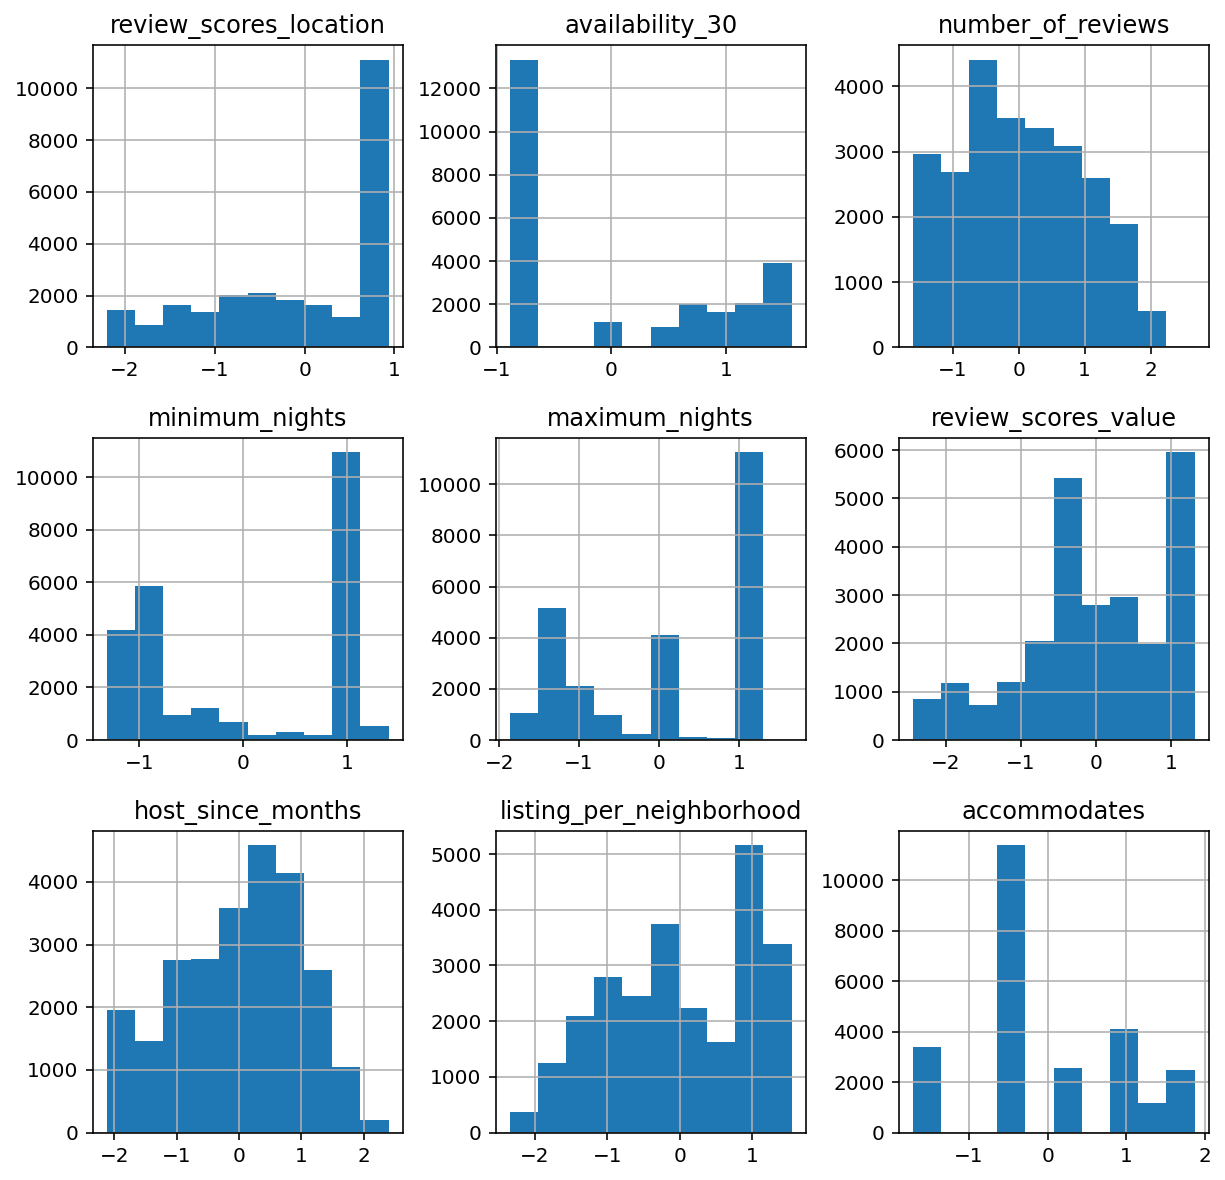

In [ ]:
# Plot the distribution of transformed numerical categories
X_train_transformed.hist(figsize=(10,10));

Most of the variables are still not normally distributed.

In [ ]:
# merge transformed df with the main df
X_train = X_train.join(X_train_transformed)
X_train.shape

(25107, 71)

Let's follow the same steps for test dataset:

In [ ]:
X_test_skewed=X_test[[ 'review_scores_location','availability_30', 'number_of_reviews','minimum_nights','maximum_nights',
       'review_scores_value','host_since_months','listing_per_neighborhood', 'accommodates']] 

In [ ]:
# Only transform
X_test_trans = power.transform(X_test_skewed)

# Save it as dataframe

X_test_transformed= pd.DataFrame(X_test_trans, columns=X_test_skewed.columns)

In [ ]:
# Drop the original columns
X_test.drop(columns=X_test_skewed.columns,inplace=True)

In [ ]:
# merge with main df and transformed df on key values
X_test = X_test.join(X_test_transformed)
X_test.shape

(6277, 71)

The number of independent variable columns has increased to 71.

### **Addressing Multicollinearity Issue After Encoding Process**
---

We are going to use VIF and correlation matrix heatmap to drop the features whose correlation is above 60% with another feature.

In [ ]:
X_train_num=X_train.select_dtypes(include='number')

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_num.values, i) for i in range(len(X_train_num.columns))]

In [ ]:
# Reset index
vif_num=vif_data.reset_index(drop=True)

In [ ]:
# Filter columns whose VIF value is over 10
vif_num[vif_num.VIF>10]

feature         VIF
7                       neigh_harlem_manhattan  273.251743
8                 neigh_central_park_manhattan  219.872085
9                neigh_midtown_south_manhattan  126.173580
10                neigh_midtown_west_manhattan  145.118991
11                neigh_midtown_east_manhattan  126.059002
12                       neigh_lower_manhattan  336.145942
43       host_response_time_a few days or more         inf
44             host_response_time_within a day         inf
45       host_response_time_within a few hours         inf
46           host_response_time_within an hour         inf
47                    host_response_rate_0-25%         inf
48                   host_response_rate_26-50%         inf
49                   host_response_rate_51-75%         inf
50                  host_response_rate_76-100%         inf
51                  host_acceptance_rate_1-25%         inf
52                 host_acceptance_rate_26-50%         inf
53                 host_acceptance_rate_51-75%         inf
54                host_acceptance_rate_76-100%         inf
55          neighbourhood_group_cleansed_Bronx         inf
56       neighbourhood_group_cleansed_Brooklyn         inf
57      neighbourhood_group_cleansed_Manhattan         inf
58         neighbourhood_group_cleansed_Queens         inf
59  neighbourhood_group_cleansed_Staten Island         inf
60                   room_type_Entire home/apt         inf
61                      room_type_Private room         inf

Method II:

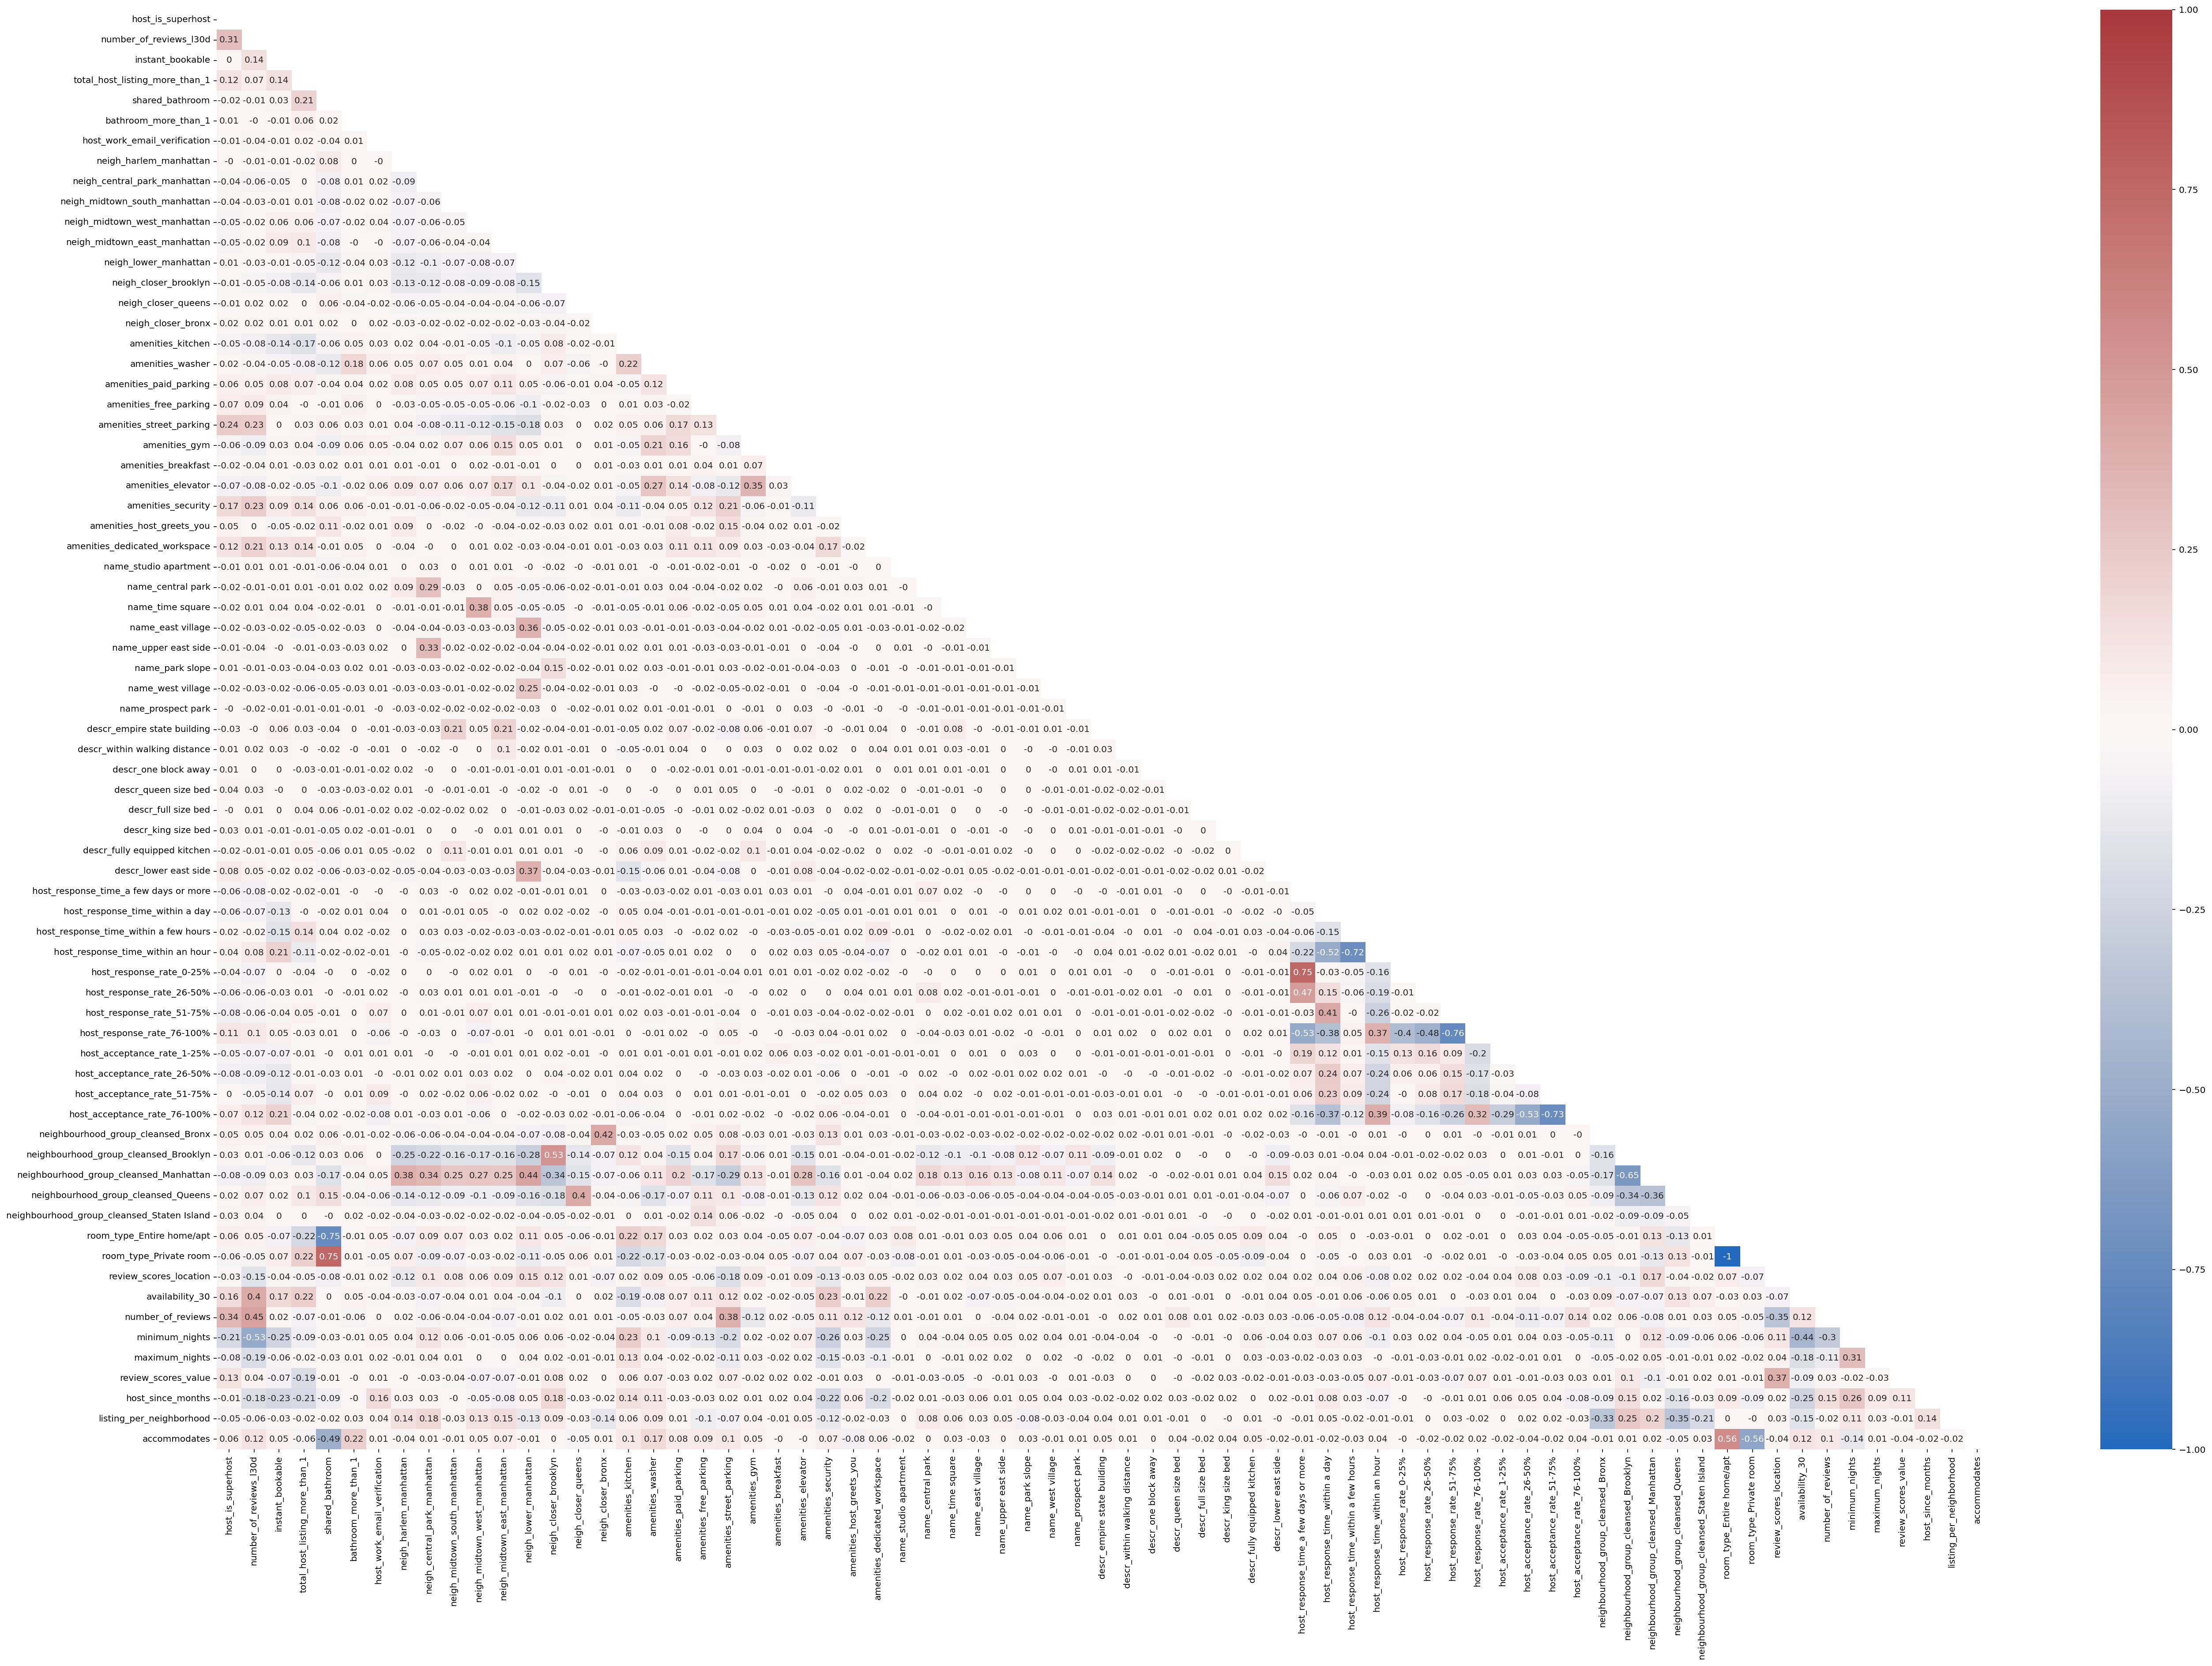

In [ ]:
# Select only numerical columns
X_train_num=X_train.select_dtypes(include='number')
matrix = X_train_num.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))

plt.figure(figsize=(45,30))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

- As a result of encoding some columns, we need to drop one of its values to eliminate the correlation. These columns are `host_response_rate`, `host_response_time`, `neighbourhood_group_cleansed`, `host_acceptance_rate`, and `room_type`. 


- Apparently Entire home column is positively correlated with `accommodates`, and negatively correlated with `shared_bathroom` columns. On the other hand private room listings are negatively correlated with `accommodates` but positively correlated with `shared bathroom` which makes sense. We were going to drop either `room_type_entire_home` or `room_type_private_room` as a result of encoding them.


- We may also need to drop either Manhattan or Brooklyn borough column due to the negative correlation between them.

- `host_response_rate` and `host_response_time` are highly positively correlated with each other. We think it is due to the unknown values.

We have decided to drop the following columns: `room_type_Private room`,`shared_bathroom`,`host_response_rate`,`neighbourhood_group_cleansed_Brooklyn`


In [ ]:
# Drop the highly correlated columns
X_train=X_train.drop(columns=['room_type_Private room','host_response_rate_51-75%','host_acceptance_rate_51-75%','host_response_time_within a few hours','neighbourhood_group_cleansed_Brooklyn'],axis=1) 
X_test=X_test.drop(columns=['room_type_Private room','host_response_rate_51-75%','host_acceptance_rate_51-75%','host_response_time_within a few hours','neighbourhood_group_cleansed_Brooklyn'],axis=1)  

In [ ]:
X_train_num=X_train.select_dtypes(include='number')

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_num.values, i) for i in range(len(X_train_num.columns))]


# Reset index
vif_num=vif_data.reset_index(drop=True)


# Filter columns whose VIF value is over 10
vif_num[vif_num.VIF>10]


feature          VIF
7                   neigh_harlem_manhattan   301.006083
8             neigh_central_park_manhattan   237.035280
9            neigh_midtown_south_manhattan   131.465143
10            neigh_midtown_west_manhattan   152.165576
11            neigh_midtown_east_manhattan   131.302042
12                   neigh_lower_manhattan   380.524760
16                       amenities_kitchen    10.194428
48              host_response_rate_76-100%    19.990948
53  neighbourhood_group_cleansed_Manhattan  1328.746275

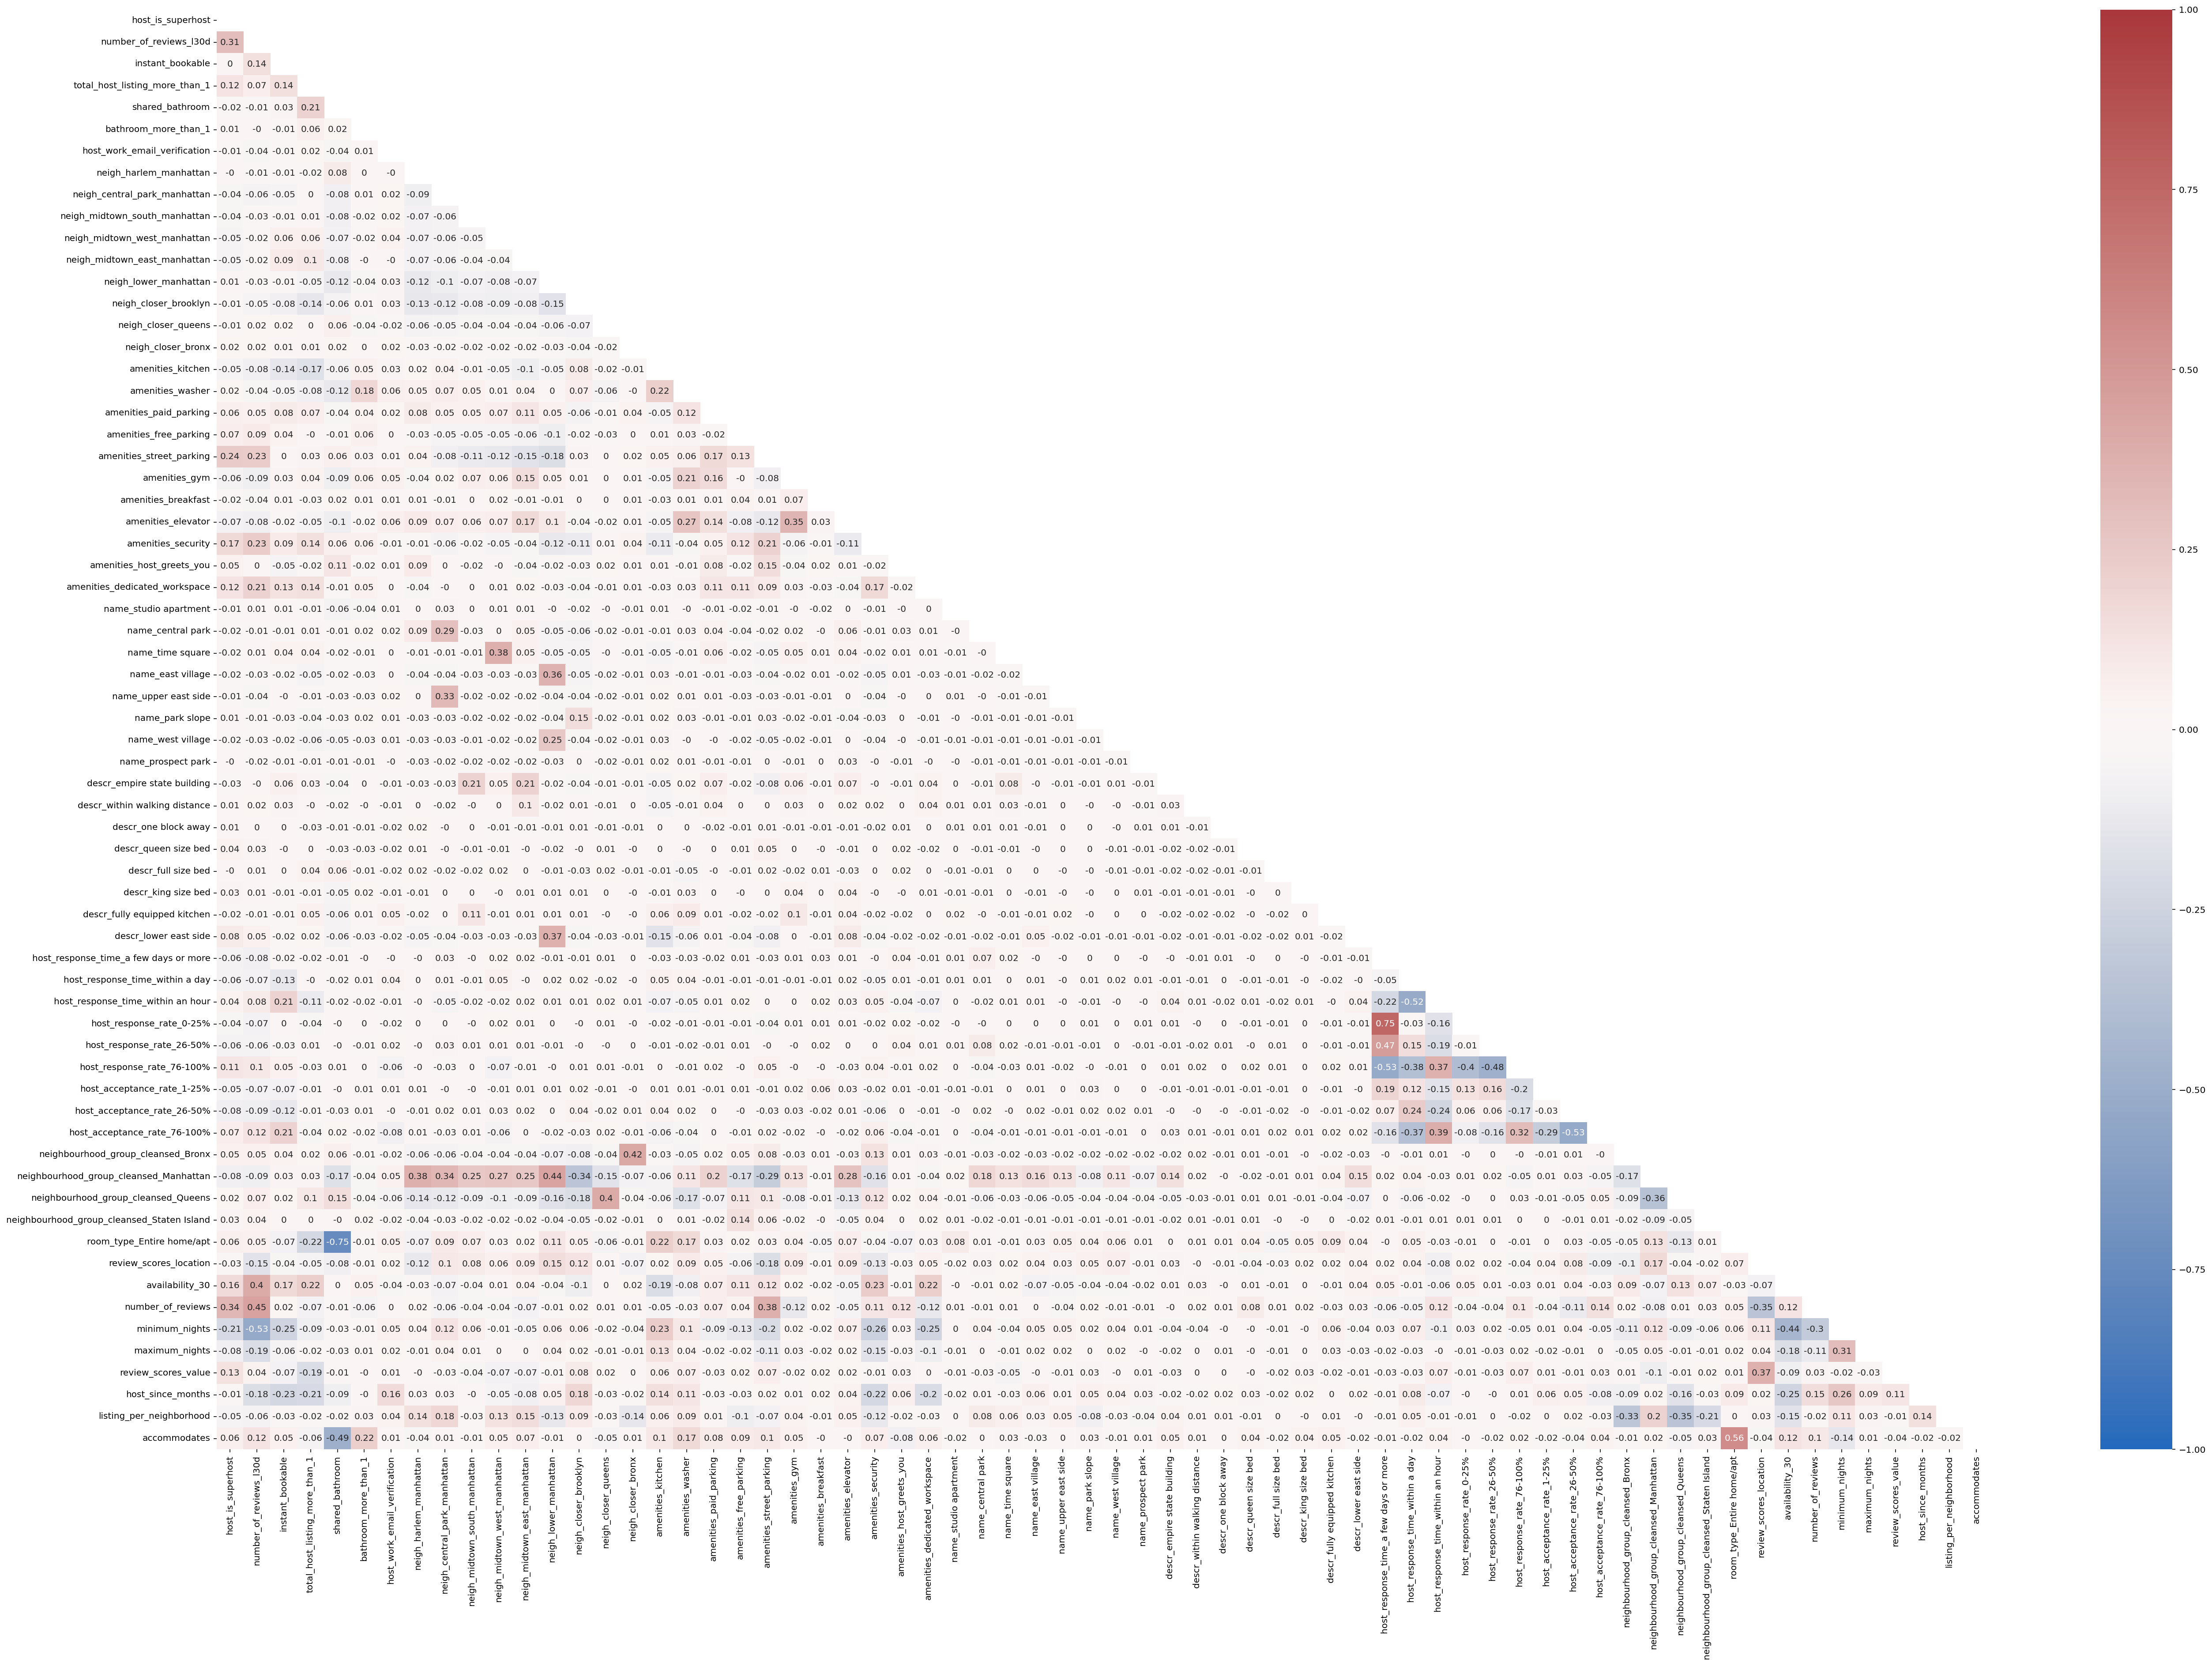

In [ ]:
# Double check

# Select only numerical columns
X_train_num=X_train.select_dtypes(include='number')
matrix = X_train_num.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))

plt.figure(figsize=(45,30))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

In [ ]:
# Drop the highly correlated columns
X_train=X_train.drop(columns=['shared_bathroom','host_response_rate_0-25%'],axis=1)
X_test=X_test.drop(columns=['shared_bathroom','host_response_rate_0-25%'],axis=1)


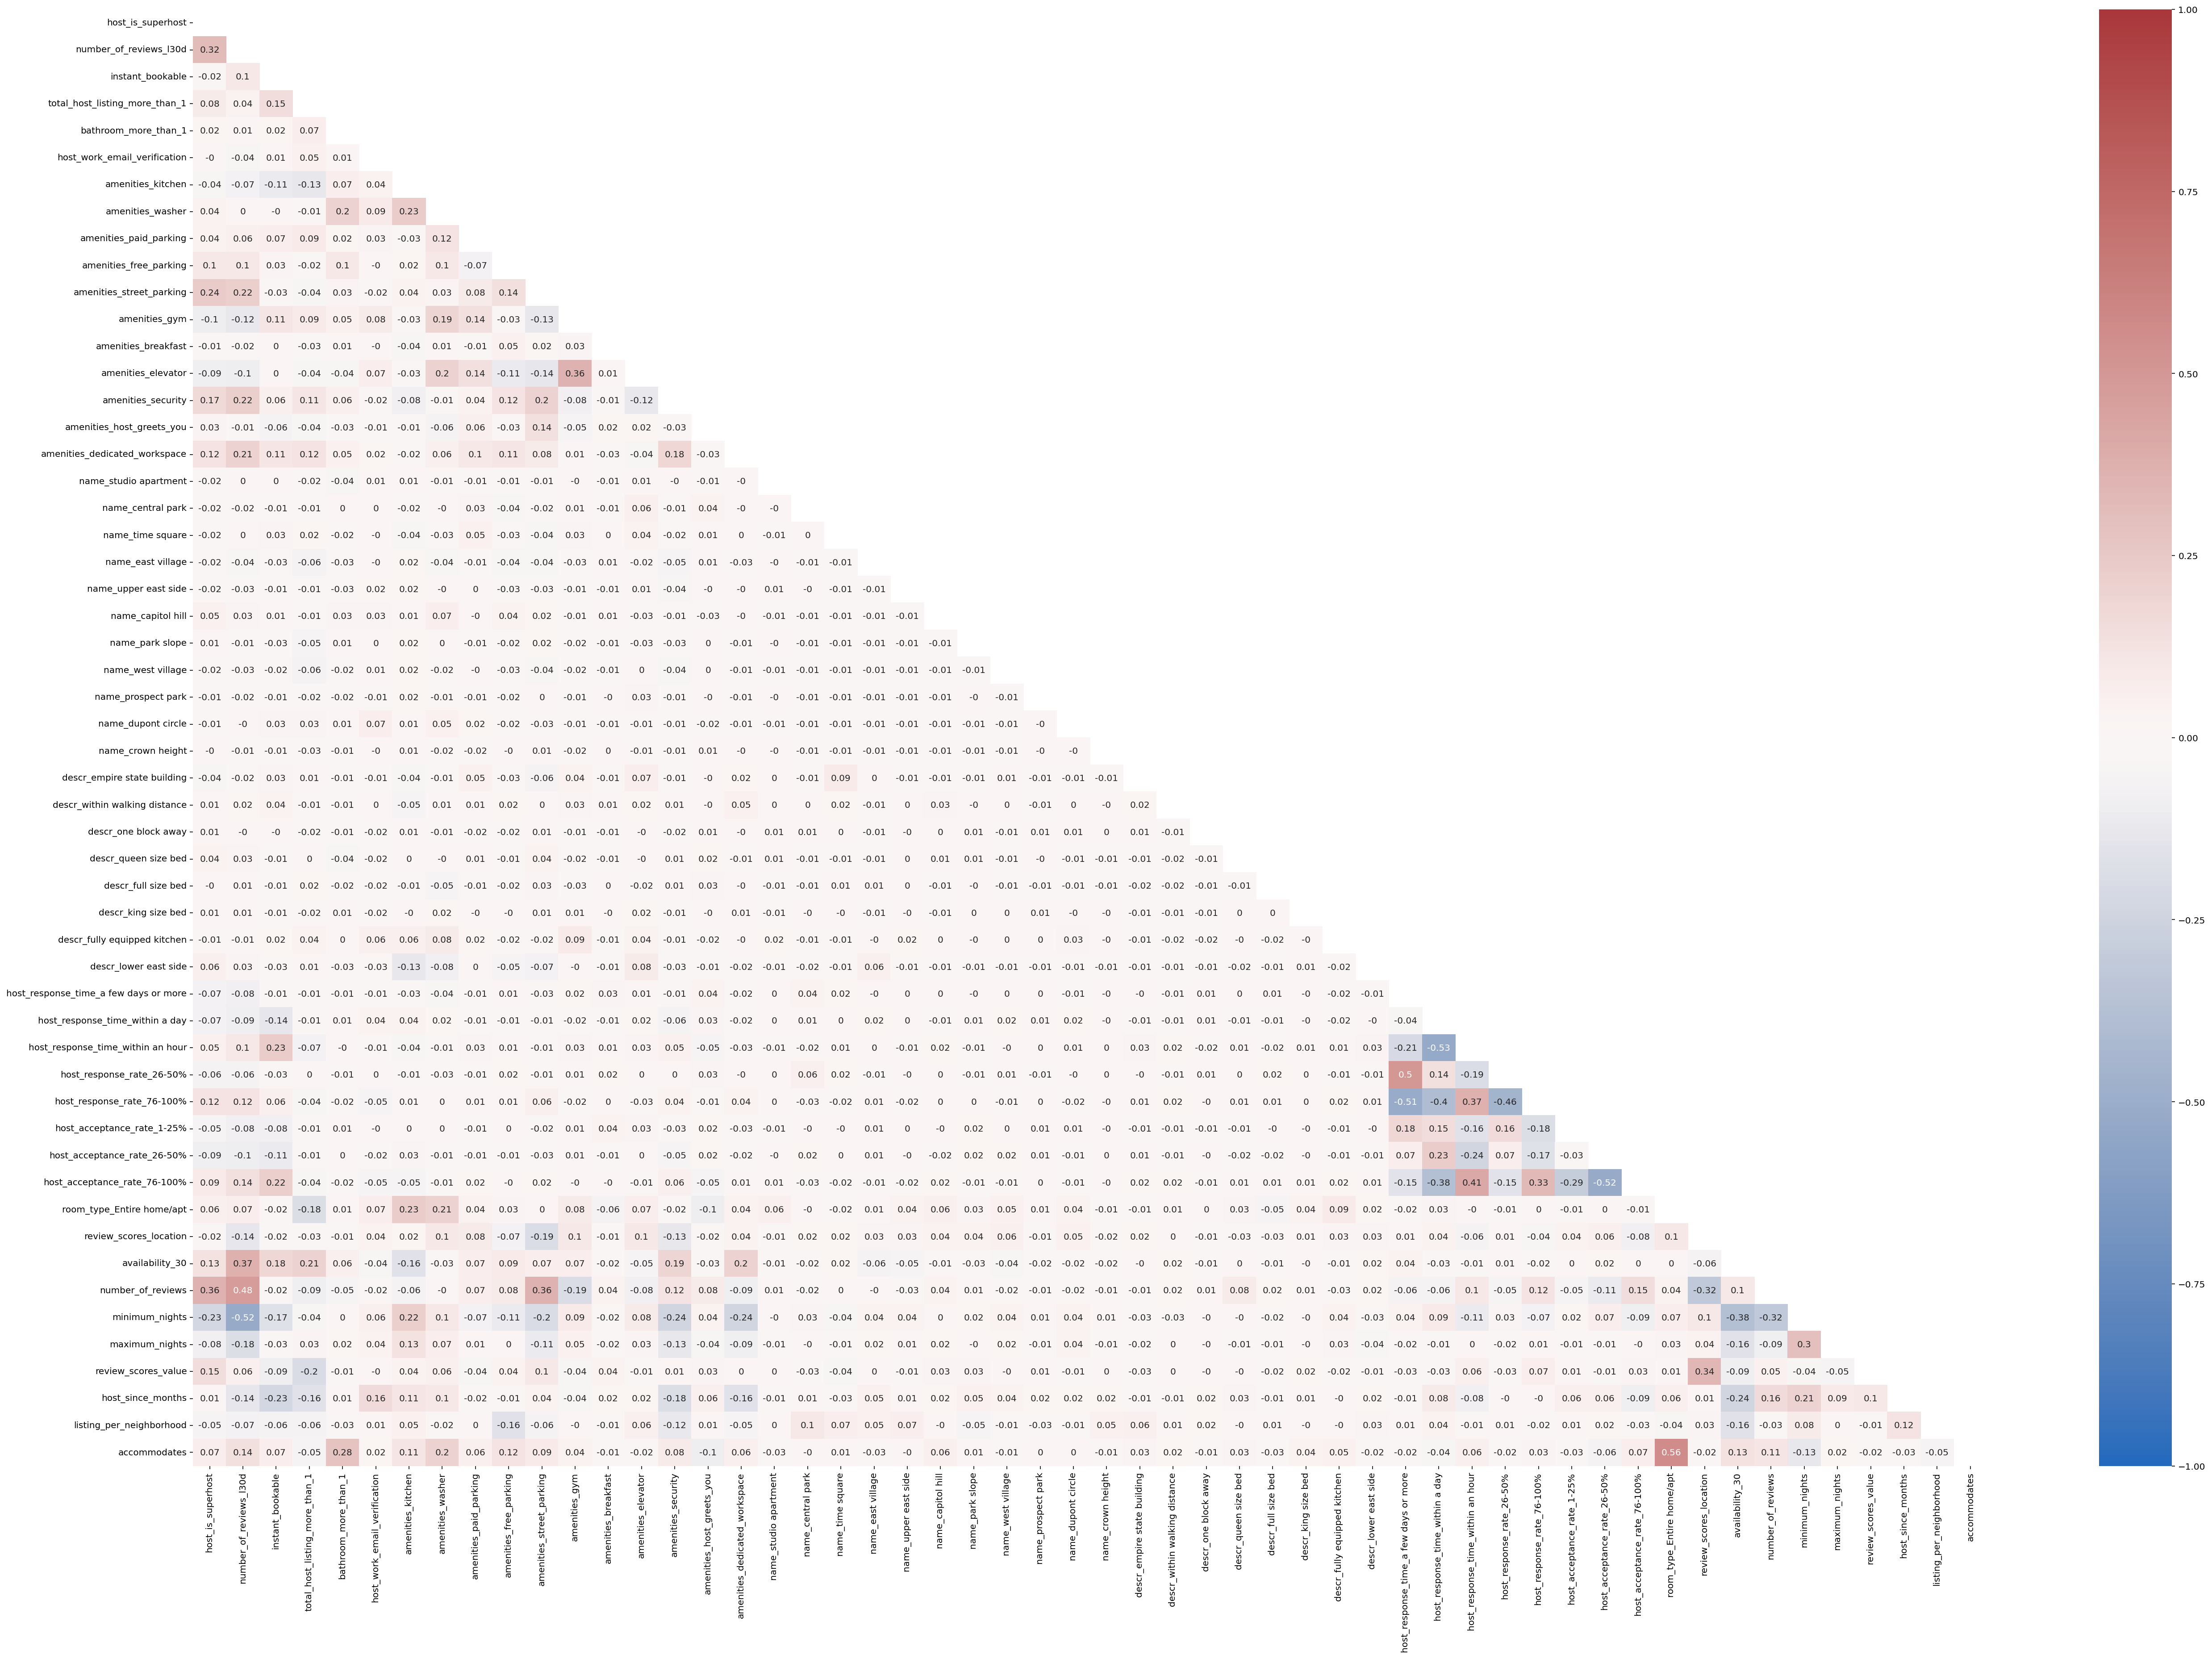

In [ ]:
# Double check

# Select only numerical columns
X_train_num=X_train.select_dtypes(include='number')
matrix = X_train_num.corr().round(2)
mask = np.triu(np.ones_like(matrix, dtype=bool))

plt.figure(figsize=(45,30))
sns.heatmap(matrix, annot=True, vmax=1, vmin=-1, center=0, cmap='vlag', mask=mask)
plt.show()

In [ ]:
X_train.shape

(25107, 64)

The final number of the variables is 64. We can export the preprocessed datasets which are ready to use for modelling.

In [ ]:
# Export all datasets including independent datasets
X_train.to_csv('/content/drive/My Drive/X_train.csv', encoding='utf-8', index=False)
X_test.to_csv('/content/drive/My Drive/X_test.csv', encoding='utf-8', index=False)

# Export all dependent datasets

y_train.to_csv('/content/drive/My Drive/y_train.csv', encoding='utf-8', index=False)
y_test.to_csv('/content/drive/My Drive/y_test.csv', encoding='utf-8', index=False)

**Next Step:**

- We will fit the data to multiple Linear Regression Models (OSL,Linear,Ridge, Lasso, ElasticNetCV). 

- The models with lowest computation cost and higher scores will be selected for optimization step. 

# **BrainStation Capstone Project**   

---



### **Airbnb Price Prediction in NYC** 

Sole contributor: Aslinur Acarlioglu

Date: August 28, 2022

Notebook: 2 of 4